# Framework


> Sampling method:

Hamiltonian Monte Carlo, kernel: No-U-Turn Sampler (NUTS)
key parameters on MCMC:
- step size e 
- number steps L: too large (waste computation), too small bad random walk (<<-- nuts fixes this !)

> Parameters: 
Each model should have the following parameters:
-  iter_sampling : 1000,
-  iter_warmup : 1000,
-  chains : 4,
-  thin : 1,
-  seed : 42,
-  adapt_delta : 0.95,
-  max_treedepth : 15


> Benchmark on:

1) Max Memory usage (at max point)
1) Time performance 
1) Fitness of model (WAIC and LOO-CV)
1) Accuracy


<table>
  <thead style="background-color: #7A8450; color: white;">
    <tr>
      <th>Parameter/Feature</th>
      <th>PyMC</th>
      <th>Stan</th>
      <th>TensorFlow Probability</th>
      <th>Turing.jl</th>
    </tr>
  </thead>
  <tbody>
    <tr style="background-color: #95969D; color:black">
      <td>Number of Iterations</td>
      <td>Specified as first argument in pm.sample</td>
      <td>iter_sampling</td>
      <td>N/A, controlled via num_results in sample_chain</td>
      <td>iterations in sample</td>
    </tr>
    <tr style="background-color: #000000; color: white;">
      <td>Warm-up/Tuning Iterations</td>
      <td>tune</td>
      <td>iter_warmup</td> 
      <td>N/A, part of num_burnin_steps in sample_chain</td>
      <td>Tuning is automatic and not directly specified</td>
    </tr>
    <tr style="background-color: #95969D; color:black">
      <td>Number of Chains</td>
      <td>chains</td>
      <td>chains</td>
      <td>Implicitly controlled by parallel execution or manually</td>
      <td>chains in sample</td>
    </tr>
    <tr style="background-color: #000000; color: white;">
      <td>Seed</td>
      <td>random_seed</td>
      <td>seed</td>
      <td>Set globally or via kernel options</td>
      <td>rng_seed in sample</td>
    </tr>
    <tr style="background-color: #95969D; color:black">
      <td>Target Acceptance Rate</td>
      <td>target_accept</td>
      <td>adapt_delta</td>
      <td>Controlled via step_size adaptation settings</td>
      <td>Specified in HMC/NUTS step methods</td>
    </tr>
    <tr style="background-color: #000000; color: white;">
      <td>Maximum Tree Depth</td>
      <td>max_treedepth</td>
      <td>max_treedepth</td>
      <td>Controlled via num_leapfrog_steps or equivalent</td>
      <td>max_depth in NUTS configuration</td>
    </tr>
    <tr style="background-color: #95969D; color:black">
      <td>Initial Values</td>
      <td>start parameter in pm.sample</td>
      <td>Specified via inits parameter</td>
      <td>Initial state in current_state of sample_chain</td>
      <td>Specified in sample method</td>
    </tr>
    <tr style="background-color: #000000; color: white;">
      <td>Step Size</td>
      <td>Automatically tuned, can be influenced by init</td>
      <td>Automatically tuned, can be manually set</td>
      <td>Specified in HMC kernel, auto-tuned in SimpleStepSizeAdaptation</td>
      <td>Specified in step method, e.g., HMC or NUTS</td>
    </tr>
   <tr style="background-color: #95969D; color:black">
      <td>Metric (Mass Matrix/Covariance)</td>
      <td>Automatically adapted</td>
      <td>Automatically adapted</td>
      <td>Can specify via experimental_compile in HMC</td>
      <td>Automatic in NUTS, can be specified</td>
    </tr>
 

  </tbody>
</table>

# AGENDA

1) Synthetic data creation
1) Stan
1) PYMC
1) TF
1) JULIA
1) Benchmark - All models
1) Conclusion

# 1) Synthetic Data Creation


In [3]:
import numpy as np
import pandas as pd

np.random.seed(42)

for N in np.linspace(100, 1000, 10):
  tv = np.random.uniform(1000, 5000, int(N))  
  lnl = np.random.uniform(500, 2500, int(N))  
  social = np.random.uniform(1000, 3000, int(N))  
  display = np.random.uniform(800, 2000, int(N))  
  email = np.random.uniform(400, 1500, int(N))  
  search = np.random.uniform(200, 1000, int(N))  
  noice = np.random.normal(0, 200, int(N))
  
  base_sales = 5000 
  sales = (base_sales +
          tv * 0.3 +
          lnl * 0.05 +
          social * 0.2 +
          display * 0.25 +
          email * 0.15 +
          search * 0.1 +
          noice)  
  
 
  df = pd.DataFrame({
      'tv': tv,
      'lnl': lnl,
      'social': social,
      'display': display,
      'email': email,
      'search': search,
      'sales': sales
  }) 
  
  csv_file_path = f'./synthetic_data/marketing_data_samples_{int(N)}.csv'
  df.to_csv(csv_file_path, index=False)
  print('CSV file saved to:', csv_file_path)
 

CSV file saved to: ./synthetic_data/marketing_data_samples_100.csv
CSV file saved to: ./synthetic_data/marketing_data_samples_200.csv
CSV file saved to: ./synthetic_data/marketing_data_samples_300.csv
CSV file saved to: ./synthetic_data/marketing_data_samples_400.csv
CSV file saved to: ./synthetic_data/marketing_data_samples_500.csv
CSV file saved to: ./synthetic_data/marketing_data_samples_600.csv
CSV file saved to: ./synthetic_data/marketing_data_samples_700.csv
CSV file saved to: ./synthetic_data/marketing_data_samples_800.csv
CSV file saved to: ./synthetic_data/marketing_data_samples_900.csv
CSV file saved to: ./synthetic_data/marketing_data_samples_1000.csv


# 2) STAN

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import os
from datetime import datetime 

from sklearn.preprocessing import StandardScaler


from cmdstanpy import CmdStanModel
 

import time
from memory_profiler import memory_usage

import daft
 
np.random.seed(42)

ModuleNotFoundError: No module named 'sklearn'

In [5]:
biggest_number = 1000
seed = 42
iter_sampling = 1000
iter_warmup = 1000
chains = 4
thin = 1
adapt_delta = 0.95
max_treedepth = 15

records = []

## TIME

In [6]:
stan_file_path = './time_outputs/stan.csv'

for seed in np.random.randint(1, 10000, size=10):
  for N in np.linspace(100, biggest_number, 10):
    df = pd.read_csv(f'./synthetic_data/marketing_data_samples_{int(N)}.csv')
    
    data_for_stan = {
      'N': len(df),
      'tv': df['tv'].values,
      'lnl': df['lnl'].values,
      'social': df['social'].values,
      'display': df['display'].values,
      'email': df['email'].values,
      'search': df['search'].values,
      'sales': df['sales'].values
    }

    model = CmdStanModel(stan_file='mmm_model.stan')

    start_time = time.time()

    fit = model.sample(data=data_for_stan, iter_sampling=iter_sampling, iter_warmup=iter_warmup, chains=chains, thin=thin, seed=seed, adapt_delta=adapt_delta, max_treedepth=max_treedepth,
                       show_progress=False,
                       output_dir="./stan_outputs/")

    fit_time = time.time() - start_time
    now = datetime.now() 
    
    fit.save_csvfiles(dir='./stan_outputs/seed'+'-'+str(seed)+'-N-'+str(int(N)))

    record = {
          'seed': seed,
          'date': now.strftime('%y%m%d'),
          'seed-date': now.strftime('%y%m%d') + '-' + str(seed),
          'time': now.strftime('%y%m%d%H%M'),
          'model' :'STAN',
          'N' : len(df),
          'results_summary' : fit.summary(),
          'diagnose' : fit.diagnose(),
          'fit_time' : fit_time
          }
    
    records.append(record)
    
# Check if the CSV file exists
if os.path.exists(stan_file_path):
    # Read the existing CSV file
    df_existing = pd.read_csv(stan_file_path)
    
    # Convert the list of new records into a DataFrame
    df_new_records = pd.DataFrame(records)
    
    # Append the new records to the existing DataFrame
    df_updated = pd.concat([df_existing, df_new_records], ignore_index=True)

else:
    # If the file does not exist, create a DataFrame from the new records
    df_updated = pd.DataFrame(records)

# Save the updated DataFrame to a CSV file
df_updated.to_csv(stan_file_path, index=False)

10:53:26 - cmdstanpy - INFO - CmdStan start processing
10:53:26 - cmdstanpy - INFO - Chain [1] start processing
10:53:26 - cmdstanpy - INFO - Chain [2] start processing
10:53:26 - cmdstanpy - INFO - Chain [3] start processing
10:53:26 - cmdstanpy - INFO - Chain [4] start processing
10:53:29 - cmdstanpy - INFO - Chain [1] done processing
10:53:29 - cmdstanpy - INFO - Chain [3] done processing
10:53:30 - cmdstanpy - INFO - Chain [2] done processing
10:53:30 - cmdstanpy - INFO - Chain [4] done processing
10:53:30 - cmdstanpy - INFO - CmdStan start processing
10:53:30 - cmdstanpy - INFO - Chain [1] start processing
10:53:30 - cmdstanpy - INFO - Chain [2] start processing
10:53:30 - cmdstanpy - INFO - Chain [3] start processing
10:53:30 - cmdstanpy - INFO - Chain [4] start processing
10:53:35 - cmdstanpy - INFO - Chain [2] done processing
10:53:36 - cmdstanpy - INFO - Chain [3] done processing
10:53:36 - cmdstanpy - INFO - Chain [4] done processing
10:53:37 - cmdstanpy - INFO - Chain [1] do

<AxesSubplot:xlabel='N', ylabel='fit_time'>

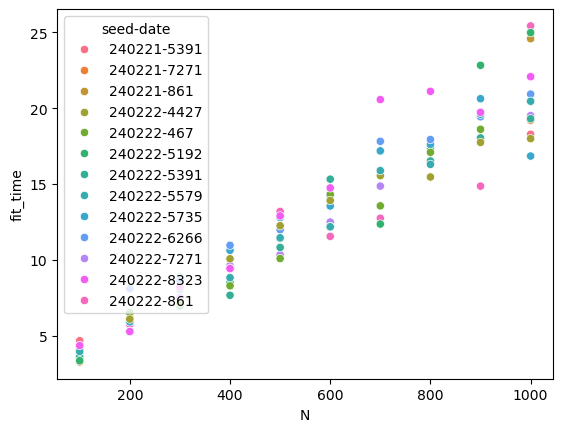

In [7]:
df = pd.read_csv(stan_file_path)
df['seed-date'] = pd.Categorical(df['seed-date']) 
sns.scatterplot(data=df, x='N', y='fit_time', hue='seed-date')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust plot to make room for the outside legend
plt.tight_layout()

# Show the plot
plt.show()

## MEMORY

In [9]:

stan_memory_trials = []
for seed in np.random.randint(1, 10000, size=10):
    def run_model_sample():

        df = pd.read_csv(f'./synthetic_data/marketing_data_samples_{biggest_number}.csv')

        data_for_stan = {
            'N': len(df),
            'tv': df['tv'].values,
            'lnl': df['lnl'].values,
            'social': df['social'].values,
            'display': df['display'].values,
            'email': df['email'].values,
            'search': df['search'].values,
            'sales': df['sales'].values
        }

        model = CmdStanModel(stan_file='mmm_model.stan')

        fit = model.sample(data=data_for_stan, iter_sampling=100, iter_warmup=100, chains=4, thin=thin, seed=seed, adapt_delta=adapt_delta, show_progress=False, max_treedepth=max_treedepth)

        
        return fit.summary(), fit.diagnose()

    
    mem_usage = memory_usage(proc=run_model_sample, max_usage=True, include_children=True, retval=True)

    
    peak_memory = mem_usage

    trial = { 'seed': seed, 'peak_memory': peak_memory}
    
    # Results
    print(f"Peak memory usage: {peak_memory} MiB")
    stan_memory_trials.append(trial)

stan_memory_df = pd.DataFrame(stan_memory_trials)
#save to csv but if file exists, append to it
if os.path.exists('./stan_outputs/stan_memory.csv'):
    stan_memory_df.to_csv('./stan_outputs/stan_memory.csv', mode='a', header=False, index=False)
else:
    stan_memory_df.to_csv('./stan_outputs/stan_memory.csv', index=False)
    

12:34:42 - cmdstanpy - INFO - CmdStan start processing
12:34:42 - cmdstanpy - INFO - Chain [1] start processing
12:34:42 - cmdstanpy - INFO - Chain [2] start processing
12:34:42 - cmdstanpy - INFO - Chain [3] start processing
12:34:42 - cmdstanpy - INFO - Chain [4] start processing
12:34:51 - cmdstanpy - INFO - Chain [4] done processing
12:34:55 - cmdstanpy - INFO - Chain [1] done processing
12:34:56 - cmdstanpy - INFO - Chain [3] done processing
12:34:59 - cmdstanpy - INFO - Chain [2] done processing
12:34:59 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (3.0%)
	Chain 1 had 1 iterations at max treedepth (1.0%)
	Chain 2 had 1 iterations at max treedepth (1.0%)
	Chain 3 had 1 iterations at max treedepth (1.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Peak memory usage: (455.60546875, (                     Mean        MCSE      StdDev           5%          50%  \
lp__         -6826.390000  121.887000  243.575000 -7047.350000 -6950.480000   
alpha         1108.160000  468.546000  978.709000   129.745000   628.208000   
beta_tv          0.463635    0.019188    0.041677     0.382048     0.477561   
beta_lnl         0.323523    0.032945    0.075728     0.181826     0.339960   
beta_social      0.572454    0.046759    0.102375     0.372416     0.610831   
beta_display     1.087900    0.101747    0.215950     0.671344     1.181470   
beta_email       0.777203    0.073195    0.166848     0.463887     0.829974   
beta_search      0.797977    0.084996    0.187934     0.453520     0.855315   
sigma          578.076000   57.355400  122.077000   338.865000   637.281000   

                      95%    N_Eff   N_Eff/s    R_hat  
lp__         -6329.340000  3.99351  0.110912  2.05152  
alpha         3038.510000  4.36317  0.121179  1.96975  
beta_t

12:35:00 - cmdstanpy - INFO - CmdStan start processing
12:35:00 - cmdstanpy - INFO - Chain [1] start processing
12:35:00 - cmdstanpy - INFO - Chain [2] start processing
12:35:00 - cmdstanpy - INFO - Chain [3] start processing
12:35:00 - cmdstanpy - INFO - Chain [4] start processing
12:35:06 - cmdstanpy - INFO - Chain [3] done processing
12:35:12 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [4] done processing
12:35:17 - cmdstanpy - INFO - Chain [2] done processing
12:35:17 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 iterations at max treedepth (1.0%)
	Chain 4 had 1 divergent transitions (1.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Peak memory usage: (455.8046875, (                     Mean        MCSE      StdDev           5%          50%  \
lp__         -6895.860000  112.329000  172.434000 -7072.820000 -6950.960000   
alpha          829.078000  507.578000  779.037000   -11.356600   624.363000   
beta_tv          0.475342    0.021569    0.036001     0.415318     0.481279   
beta_lnl         0.344167    0.036312    0.064021     0.238196     0.352592   
beta_social      0.600575    0.050144    0.080672     0.463005     0.615271   
beta_display     1.144580    0.110143    0.174020     0.853834     1.184760   
beta_email       0.825262    0.084186    0.139757     0.595005     0.853916   
beta_search      0.842672    0.088822    0.157896     0.577448     0.874294   
sigma          612.163000   65.021800  100.456000   448.496000   636.712000   

                      95%    N_Eff   N_Eff/s    R_hat  
lp__         -6608.800000  2.35648  0.062873  3.41165  
alpha         2093.320000  2.35565  0.062851  3.48963  
beta_tv

12:35:18 - cmdstanpy - INFO - CmdStan start processing
12:35:18 - cmdstanpy - INFO - Chain [1] start processing
12:35:18 - cmdstanpy - INFO - Chain [2] start processing
12:35:18 - cmdstanpy - INFO - Chain [3] start processing
12:35:18 - cmdstanpy - INFO - Chain [4] start processing
12:35:28 - cmdstanpy - INFO - Chain [3] done processing
12:35:29 - cmdstanpy - INFO - Chain [1] done processing
12:35:32 - cmdstanpy - INFO - Chain [2] done processing
12:35:34 - cmdstanpy - INFO - Chain [4] done processing
12:35:34 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 iterations at max treedepth (1.0%)
	Chain 4 had 2 iterations at max treedepth (2.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Peak memory usage: (454.03125, (                     Mean        MCSE      StdDev           5%          50%  \
lp__         -6970.060000   38.171000   88.609700 -7047.140000 -7013.120000   
alpha          509.716000  183.364000  418.128000   125.852000   304.569000   
beta_tv          0.488031    0.008261    0.024726     0.441531     0.490583   
beta_lnl         0.363924    0.011858    0.046408     0.278057     0.367635   
beta_social      0.633457    0.018700    0.053034     0.526689     0.638190   
beta_display     1.212670    0.034390    0.097433     1.007390     1.226340   
beta_email       0.877499    0.031093    0.088816     0.693091     0.893270   
beta_search      0.903096    0.038793    0.111634     0.712391     0.907829   
sigma          652.486000   23.434900   54.895500   511.700000   669.473000   

                      95%     N_Eff   N_Eff/s    R_hat  
lp__         -6700.020000   5.38885  0.142085  1.84095  
alpha         1757.230000   5.19983  0.137101  1.90733  
beta_t

12:35:35 - cmdstanpy - INFO - CmdStan start processing
12:35:35 - cmdstanpy - INFO - Chain [1] start processing
12:35:35 - cmdstanpy - INFO - Chain [2] start processing
12:35:35 - cmdstanpy - INFO - Chain [3] start processing
12:35:35 - cmdstanpy - INFO - Chain [4] start processing
12:35:43 - cmdstanpy - INFO - Chain [4] done processing
12:35:45 - cmdstanpy - INFO - Chain [1] done processing
12:35:47 - cmdstanpy - INFO - Chain [2] done processing
12:35:50 - cmdstanpy - INFO - Chain [3] done processing


Peak memory usage: (454.234375, (                     Mean        MCSE      StdDev           5%          50%  \
lp__         -6948.740000   65.543100   95.317400 -7031.820000 -6977.760000   
alpha          613.257000  312.420000  454.920000   209.444000   490.052000   
beta_tv          0.482994    0.013449    0.024711     0.437110     0.486472   
beta_lnl         0.354326    0.022733    0.045610     0.277964     0.354310   
beta_social      0.622444    0.031817    0.054821     0.522473     0.632234   
beta_display     1.196650    0.066496    0.105948     1.005890     1.226960   
beta_email       0.864222    0.053760    0.091915     0.685146     0.877882   
beta_search      0.874621    0.059496    0.118410     0.669667     0.884115   
sigma          638.529000   40.848600   60.866100   530.497000   656.251000   

                      95%    N_Eff   N_Eff/s    R_hat  
lp__         -6779.530000  2.11490  0.072940  7.93436  
alpha         1418.740000  2.12028  0.073126  7.60371  
beta_tv 

12:35:51 - cmdstanpy - INFO - CmdStan start processing
12:35:51 - cmdstanpy - INFO - Chain [1] start processing
12:35:51 - cmdstanpy - INFO - Chain [2] start processing
12:35:51 - cmdstanpy - INFO - Chain [3] start processing
12:35:51 - cmdstanpy - INFO - Chain [4] start processing
12:36:01 - cmdstanpy - INFO - Chain [4] done processing
12:36:02 - cmdstanpy - INFO - Chain [3] done processing
12:36:04 - cmdstanpy - INFO - Chain [2] done processing
12:36:06 - cmdstanpy - INFO - Chain [1] done processing
12:36:06 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 iterations at max treedepth (1.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Peak memory usage: (455.35546875, (                     Mean        MCSE      StdDev           5%          50%  \
lp__         -6937.330000   28.430100   81.445800 -7069.510000 -6912.280000   
alpha          675.145000  138.963000  401.018000     0.190546   808.920000   
beta_tv          0.481218    0.006116    0.025765     0.441736     0.479792   
beta_lnl         0.352427    0.008545    0.041905     0.286128     0.353592   
beta_social      0.615066    0.013655    0.052250     0.537966     0.607765   
beta_display     1.180230    0.030236    0.094757     1.043340     1.168840   
beta_email       0.849927    0.022927    0.088551     0.719164     0.840243   
beta_search      0.870843    0.026995    0.106468     0.712041     0.858050   
sigma          631.368000   18.246200   54.024200   549.759000   617.957000   

                      95%     N_Eff   N_Eff/s    R_hat  
lp__         -6800.580000   8.20695  0.212472  2.13984  
alpha         1327.050000   8.32774  0.215599  2.11333  
bet

12:36:07 - cmdstanpy - INFO - CmdStan start processing
12:36:07 - cmdstanpy - INFO - Chain [1] start processing
12:36:07 - cmdstanpy - INFO - Chain [2] start processing
12:36:07 - cmdstanpy - INFO - Chain [3] start processing
12:36:07 - cmdstanpy - INFO - Chain [4] start processing
12:36:16 - cmdstanpy - INFO - Chain [1] done processing
12:36:20 - cmdstanpy - INFO - Chain [2] done processing
12:36:22 - cmdstanpy - INFO - Chain [4] done processing
12:36:22 - cmdstanpy - INFO - Chain [3] done processing
12:36:22 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 iterations at max treedepth (1.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Peak memory usage: (458.71484375, (                     Mean        MCSE      StdDev           5%          50%  \
lp__         -6919.360000   23.251000   60.296200 -7062.310000 -6903.310000   
alpha          767.838000  114.271000  300.283000    39.117700   851.378000   
beta_tv          0.477744    0.004036    0.020687     0.446611     0.476546   
beta_lnl         0.345643    0.007470    0.040153     0.281916     0.342153   
beta_social      0.606439    0.011672    0.039732     0.545845     0.602738   
beta_display     1.160040    0.024170    0.079005     1.050070     1.142500   
beta_email       0.835493    0.017095    0.075557     0.723498     0.828390   
beta_search      0.853021    0.019742    0.096256     0.699309     0.843676   
sigma          618.499000   14.377600   41.120900   568.359000   608.047000   

                      95%     N_Eff   N_Eff/s    R_hat  
lp__         -6859.450000   6.72508  0.233761  1.92359  
alpha         1054.350000   6.90536  0.240028  1.90998  
bet

12:36:23 - cmdstanpy - INFO - CmdStan start processing
12:36:23 - cmdstanpy - INFO - Chain [1] start processing
12:36:23 - cmdstanpy - INFO - Chain [2] start processing
12:36:23 - cmdstanpy - INFO - Chain [3] start processing
12:36:23 - cmdstanpy - INFO - Chain [4] start processing
12:36:32 - cmdstanpy - INFO - Chain [1] done processing
12:36:36 - cmdstanpy - INFO - Chain [4] done processing
12:36:37 - cmdstanpy - INFO - Chain [3] done processing
12:36:38 - cmdstanpy - INFO - Chain [2] done processing
12:36:38 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 iterations at max treedepth (1.0%)
	Chain 3 had 1 divergent transitions (1.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Peak memory usage: (458.38671875, (                     Mean        MCSE      StdDev           5%          50%  \
lp__         -6839.790000  111.545000  169.577000 -7034.130000 -6902.830000   
alpha         1093.400000  489.358000  745.041000   200.973000   847.012000   
beta_tv          0.464543    0.019710    0.033375     0.411311     0.467396   
beta_lnl         0.321669    0.035295    0.062204     0.227024     0.323131   
beta_social      0.573228    0.048322    0.079031     0.449016     0.577453   
beta_display     1.088820    0.105424    0.165736     0.819093     1.110650   
beta_email       0.789101    0.082005    0.133858     0.567374     0.796396   
beta_search      0.798076    0.092761    0.159764     0.538959     0.807399   
sigma          577.894000   61.962700   94.503700   425.970000   599.819000   

                      95%    N_Eff   N_Eff/s    R_hat  
lp__         -6561.200000  2.31117  0.068214  3.67238  
alpha         2263.100000  2.31796  0.068415  3.62749  
beta_t

12:36:39 - cmdstanpy - INFO - CmdStan start processing
12:36:39 - cmdstanpy - INFO - Chain [1] start processing
12:36:39 - cmdstanpy - INFO - Chain [2] start processing
12:36:39 - cmdstanpy - INFO - Chain [3] start processing
12:36:39 - cmdstanpy - INFO - Chain [4] start processing
12:36:46 - cmdstanpy - INFO - Chain [4] done processing
12:36:49 - cmdstanpy - INFO - Chain [1] done processing
12:36:50 - cmdstanpy - INFO - Chain [3] done processing
12:36:56 - cmdstanpy - INFO - Chain [2] done processing
12:36:56 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (1.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Peak memory usage: (457.15625, (                     Mean        MCSE      StdDev           5%          50%  \
lp__         -6965.410000   85.450600  123.476000 -7049.530000 -7028.330000   
alpha          518.230000  403.569000  583.074000   113.371000   229.799000   
beta_tv          0.486768    0.016422    0.028514     0.436019     0.492029   
beta_lnl         0.362500    0.028903    0.054246     0.269221     0.367022   
beta_social      0.630604    0.039478    0.065172     0.513823     0.645183   
beta_display     1.214020    0.088976    0.136040     0.952204     1.261430   
beta_email       0.874922    0.067227    0.114570     0.668538     0.899135   
beta_search      0.909357    0.081752    0.144210     0.640283     0.935546   
sigma          651.754000   52.515200   76.882500   505.510000   687.983000   

                      95%    N_Eff   N_Eff/s     R_hat  
lp__         -6730.970000  2.08803  0.081883  14.24190  
alpha         1610.100000  2.08743  0.081860  14.58690  
beta_t

12:36:57 - cmdstanpy - INFO - CmdStan start processing
12:36:57 - cmdstanpy - INFO - Chain [1] start processing
12:36:57 - cmdstanpy - INFO - Chain [2] start processing
12:36:57 - cmdstanpy - INFO - Chain [3] start processing
12:36:57 - cmdstanpy - INFO - Chain [4] start processing
12:37:08 - cmdstanpy - INFO - Chain [3] done processing
12:37:09 - cmdstanpy - INFO - Chain [1] done processing
12:37:11 - cmdstanpy - INFO - Chain [4] done processing
12:37:13 - cmdstanpy - INFO - Chain [2] done processing
12:37:13 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 4 had 1 iterations at max treedepth (1.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Peak memory usage: (457.15625, (                     Mean        MCSE       StdDev           5%          50%  \
lp__         -6790.380000  154.153000   242.938000 -7044.320000 -6924.320000   
alpha         1260.220000  657.309000  1035.410000   139.006000   751.324000   
beta_tv          0.458215    0.027089     0.044709     0.395384     0.472427   
beta_lnl         0.312858    0.047444     0.078762     0.199843     0.323727   
beta_social      0.557185    0.064458     0.104812     0.408437     0.588020   
beta_display     1.054210    0.143490     0.228123     0.744747     1.167230   
beta_email       0.760416    0.110948     0.182461     0.509324     0.815905   
beta_search      0.756226    0.104220     0.182507     0.496185     0.772413   
sigma          557.970000   83.475700   131.863000   372.014000   622.694000   

                      95%    N_Eff   N_Eff/s    R_hat  
lp__         -6418.170000  2.48364  0.069025  2.91859  
alpha         2758.200000  2.48135  0.068961  2.87939  

12:37:14 - cmdstanpy - INFO - CmdStan start processing
12:37:14 - cmdstanpy - INFO - Chain [1] start processing
12:37:14 - cmdstanpy - INFO - Chain [2] start processing
12:37:14 - cmdstanpy - INFO - Chain [3] start processing
12:37:14 - cmdstanpy - INFO - Chain [4] start processing
12:37:19 - cmdstanpy - INFO - Chain [1] done processing
12:37:23 - cmdstanpy - INFO - Chain [2] done processing
12:37:26 - cmdstanpy - INFO - Chain [3] done processing
12:37:29 - cmdstanpy - INFO - Chain [4] done processing
12:37:29 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 4 had 1 iterations at max treedepth (1.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Peak memory usage: (457.08203125, (                     Mean        MCSE      StdDev           5%          50%  \
lp__         -6930.100000   51.944800   83.382100 -7042.050000 -6927.090000   
alpha          709.020000  254.648000  408.387000   153.256000   733.903000   
beta_tv          0.480176    0.010465    0.022439     0.449153     0.476359   
beta_lnl         0.352322    0.021958    0.045213     0.285558     0.348126   
beta_social      0.611402    0.024478    0.049593     0.539951     0.607940   
beta_display     1.171610    0.053049    0.096580     1.045600     1.160900   
beta_email       0.846298    0.041948    0.088010     0.701136     0.842268   
beta_search      0.863865    0.050063    0.113094     0.697422     0.856773   
sigma          626.547000   33.475900   55.409400   551.150000   615.734000   

                      95%    N_Eff   N_Eff/s    R_hat  
lp__         -6824.260000  2.57668  0.098909  3.29088  
alpha         1209.820000  2.57196  0.098728  3.28452  
beta_t

## FITNESS

In [6]:
dims = {"y": ["sales"], "x": ["sales"], "log_likelihood": ["sales"], "y_hat": ["sales"]}
idata_kwargs = {
    "posterior_predictive": ["y_hat"],
    "log_likelihood": ["log_lik"],
    "dims": dims,
}
idata = az.from_cmdstanpy(
    posterior=fit,   **idata_kwargs
)


In [9]:
az.summary(idata, var_names=['beta_tv', 'beta_lnl', 'beta_social', 'beta_display', 'beta_email', 'beta_search'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_tv       0.325  0.018   0.291    0.359      0.000    0.000    1778.0   
beta_lnl      0.163  0.035   0.090    0.225      0.001    0.001    2037.0   
beta_social   0.231  0.036   0.169    0.305      0.001    0.001    1620.0   
beta_display  0.384  0.062   0.272    0.503      0.002    0.001    1280.0   
beta_email    0.165  0.061   0.052    0.283      0.001    0.001    1769.0   
beta_search   0.264  0.090   0.101    0.444      0.002    0.002    1472.0   

              ess_tail  r_hat  
beta_tv         1108.0    1.0  
beta_lnl        1491.0    1.0  
beta_social     1493.0    1.0  
beta_display    1440.0    1.0  
beta_email      1255.0    1.0  
beta_search     1381.0    1.0

In [12]:
az.summary(fit)

mean       sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
alpha         4358.554  192.988  4006.450  4716.230      6.116    4.326   
beta_tv          0.325    0.018     0.291     0.359      0.000    0.000   
beta_lnl         0.163    0.035     0.090     0.225      0.001    0.001   
beta_social      0.231    0.036     0.169     0.305      0.001    0.001   
beta_display     0.384    0.062     0.272     0.503      0.002    0.001   
beta_email       0.165    0.061     0.052     0.283      0.001    0.001   
beta_search      0.264    0.090     0.101     0.444      0.002    0.002   
sigma          196.625   15.440   168.502   224.065      0.331    0.238   

              ess_bulk  ess_tail  r_hat  
alpha           1001.0    1376.0    1.0  
beta_tv         1778.0    1108.0    1.0  
beta_lnl        2037.0    1491.0    1.0  
beta_social     1620.0    1493.0    1.0  
beta_display    1280.0    1440.0    1.0  
beta_email      1769.0    1255.0    1.0  
beta_search     1472.0    1381.0    1.0  
sigma           2260.0    1380.0    1.0

AttributeError: module 'arviz' has no attribute 'plot_divergence'

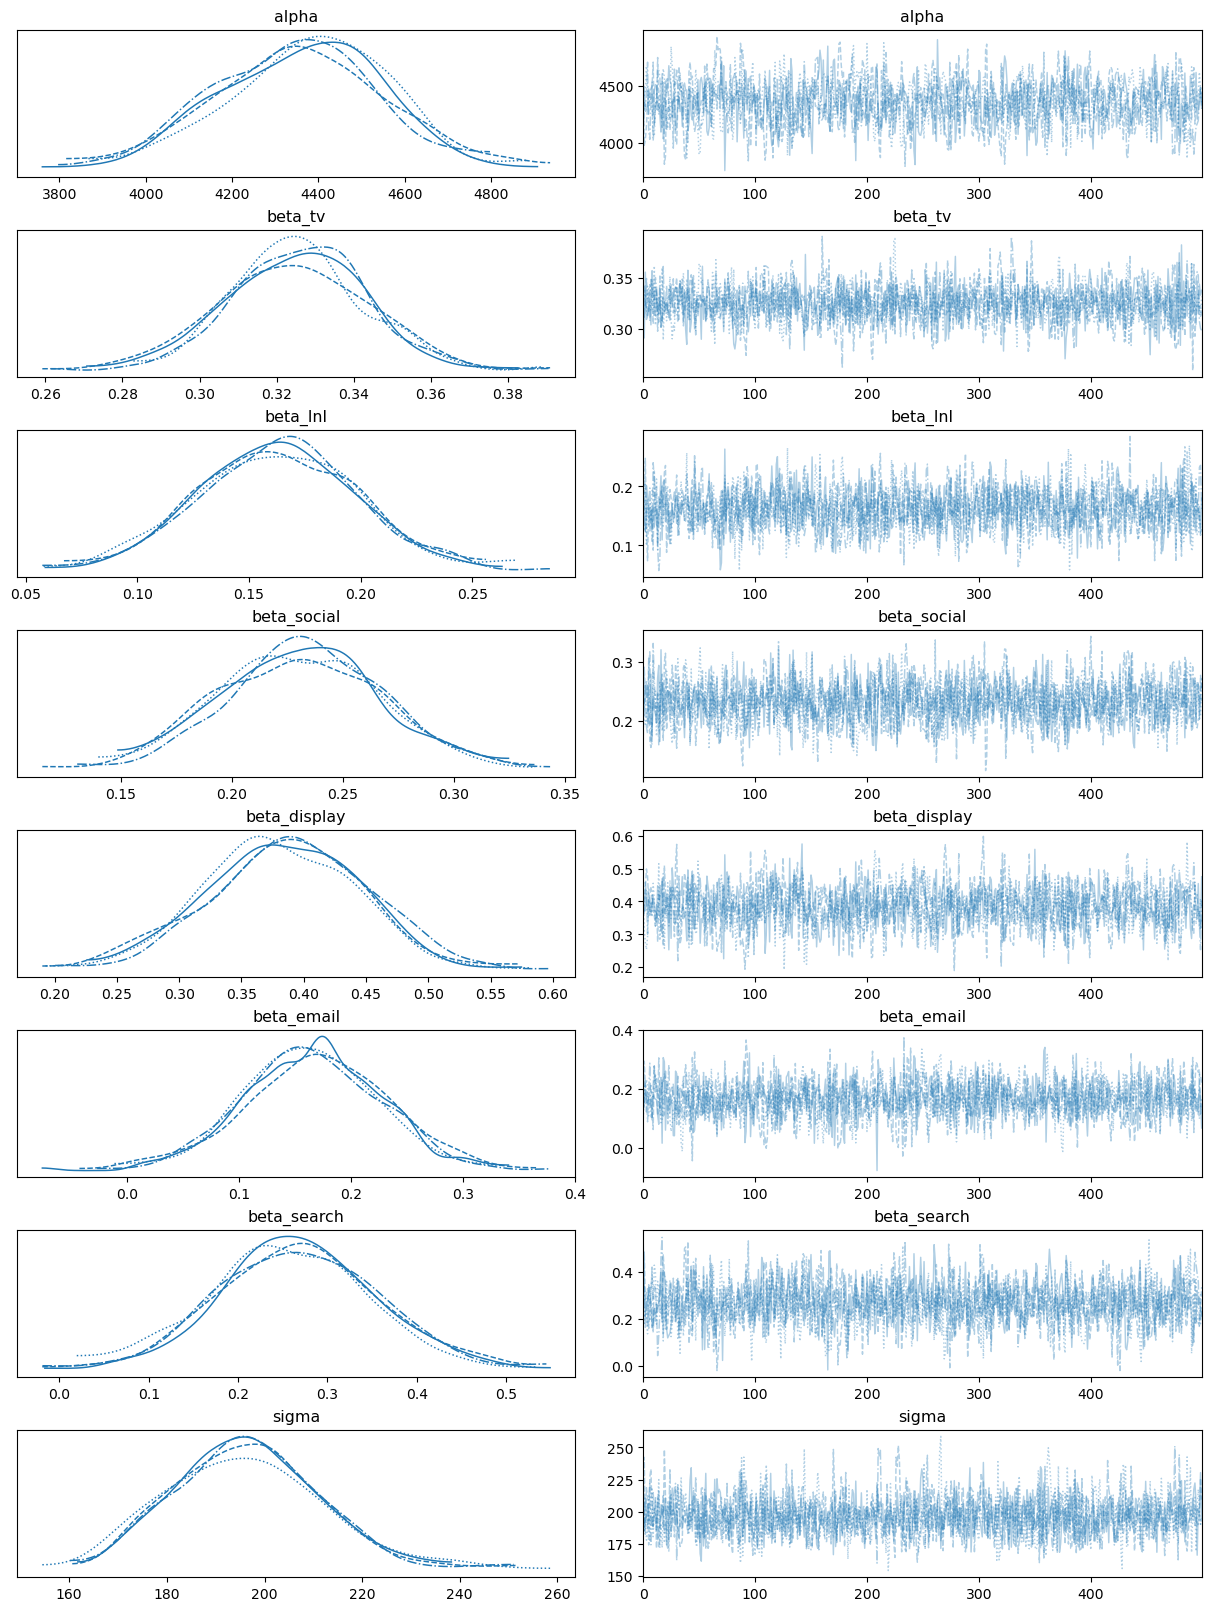

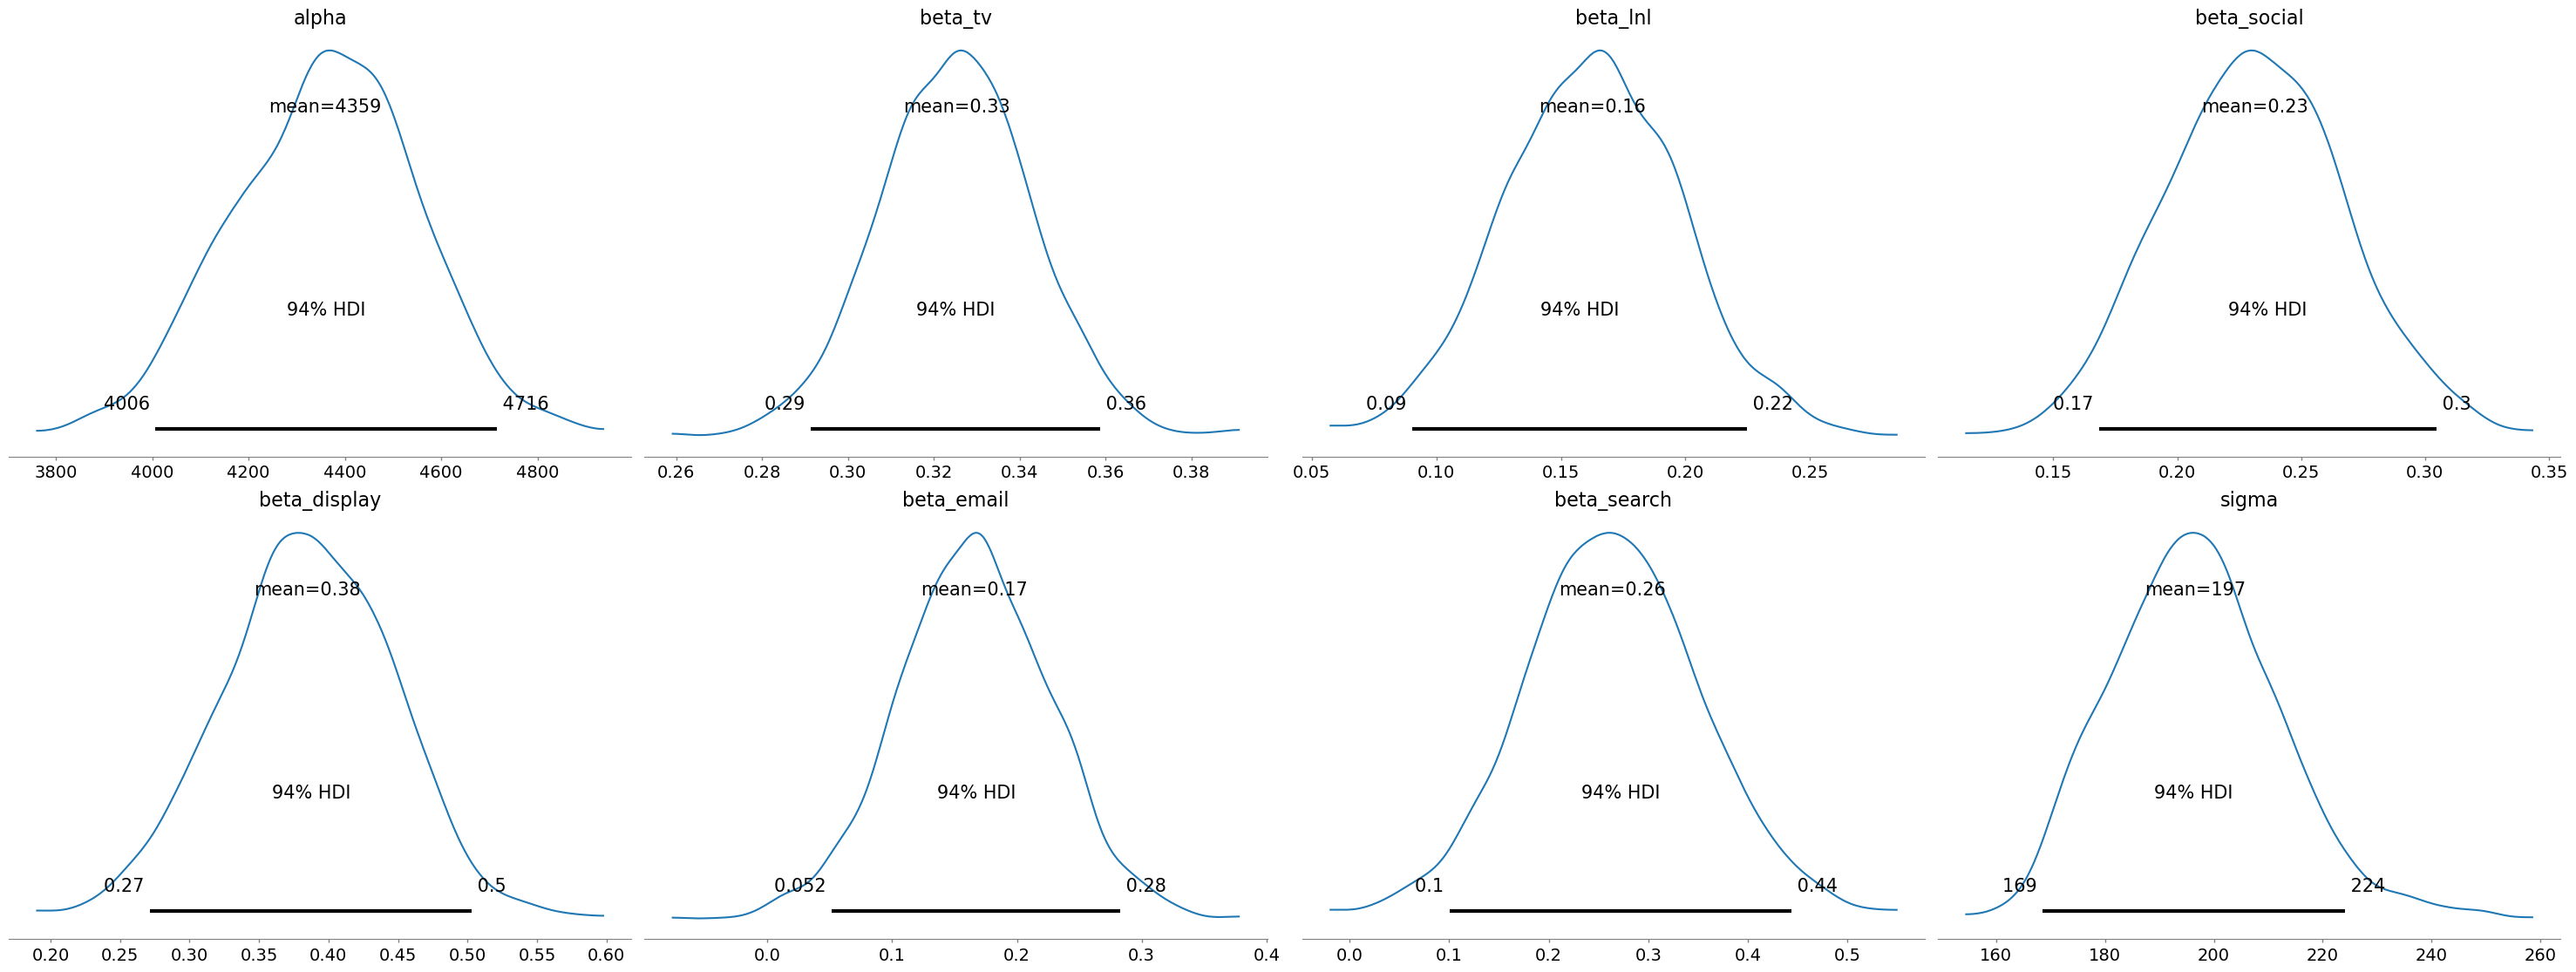

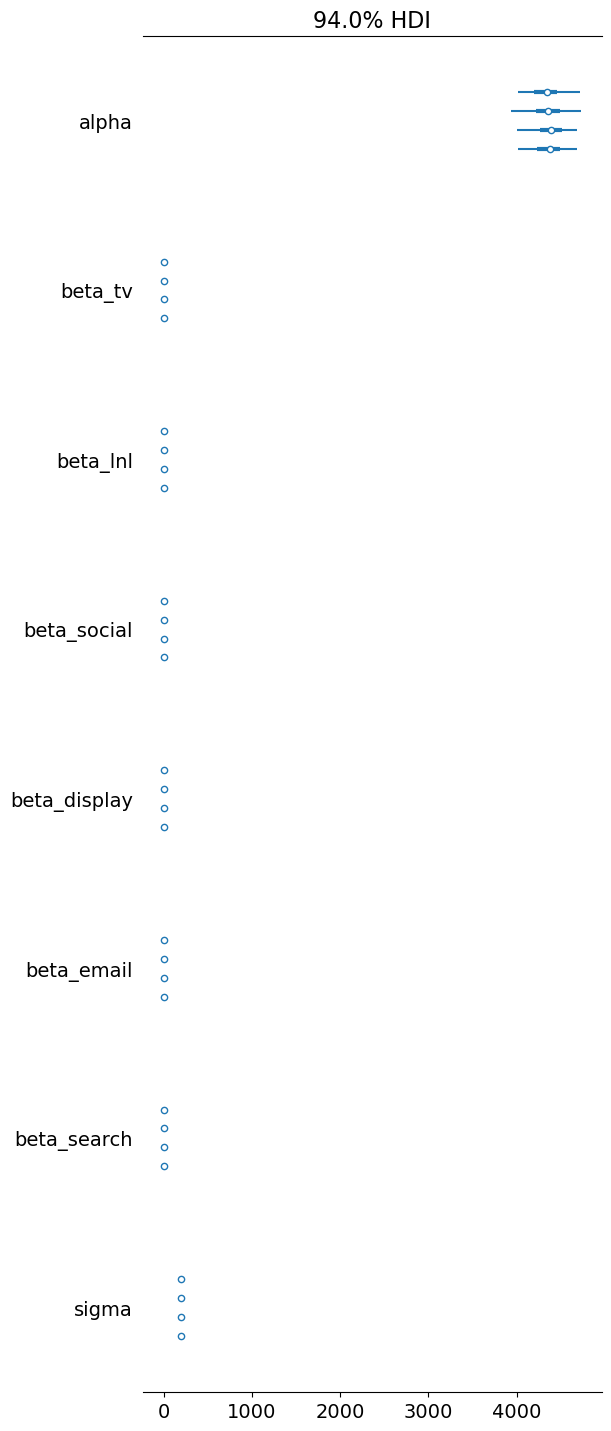

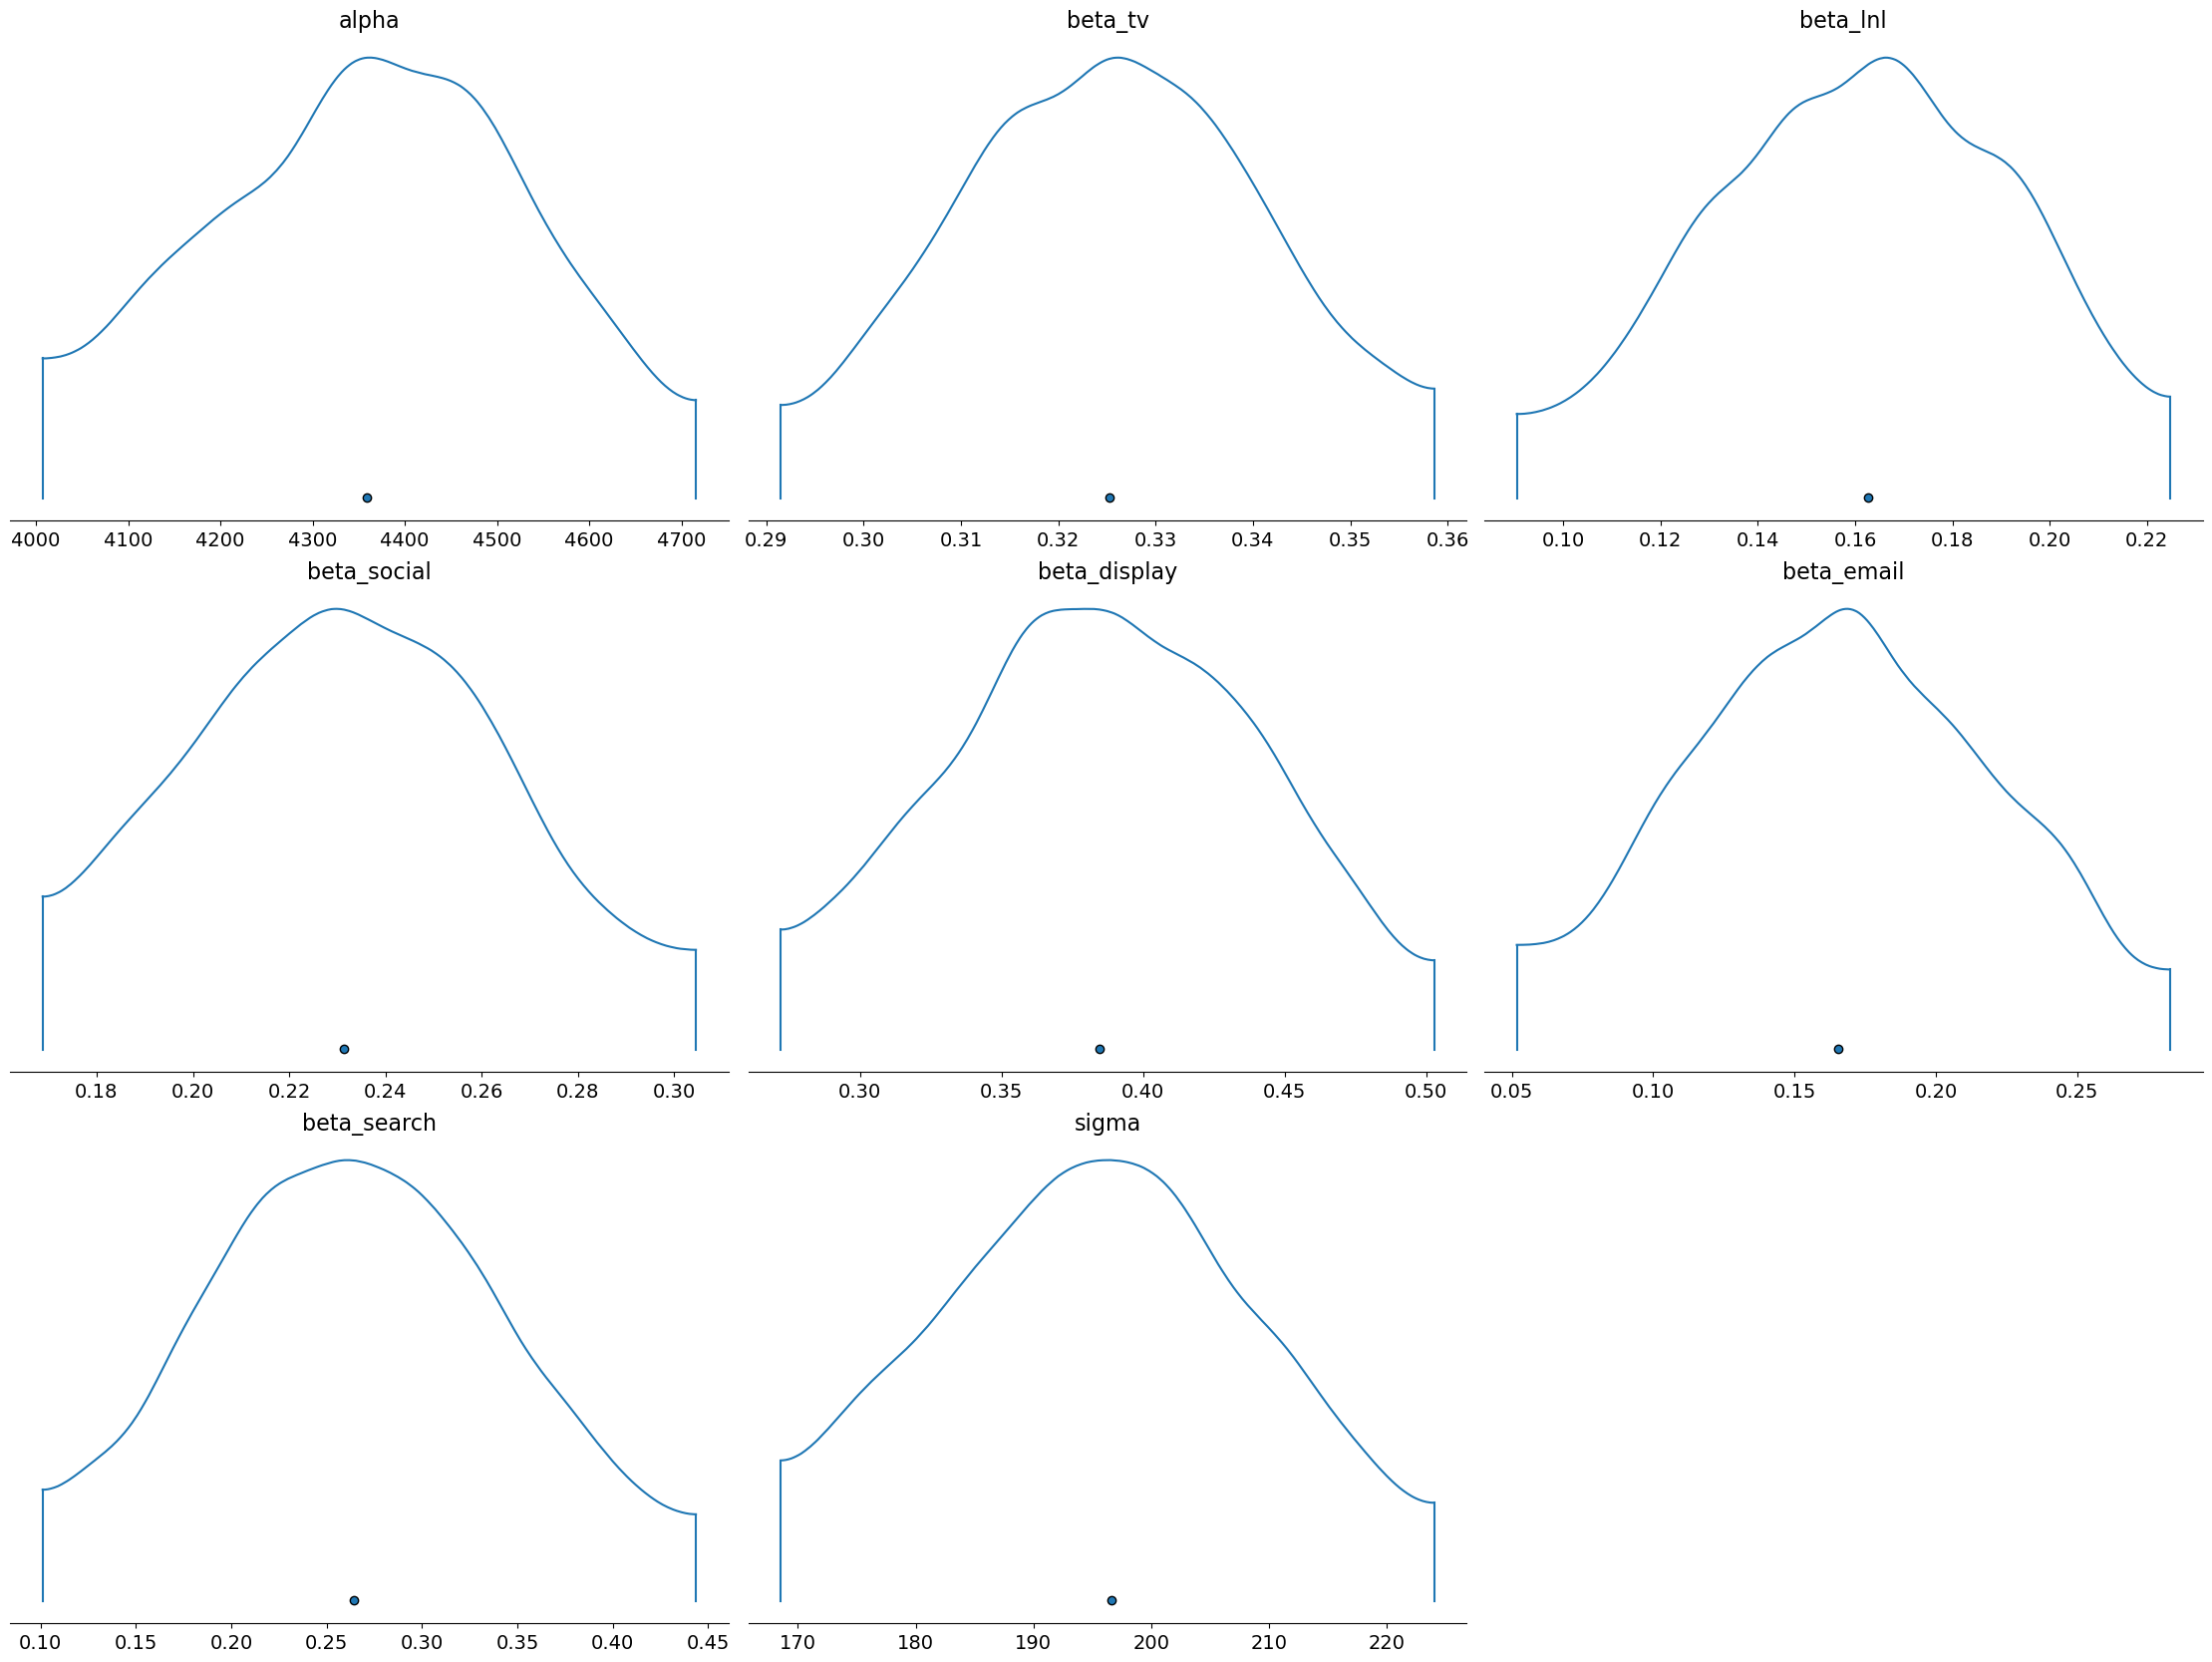

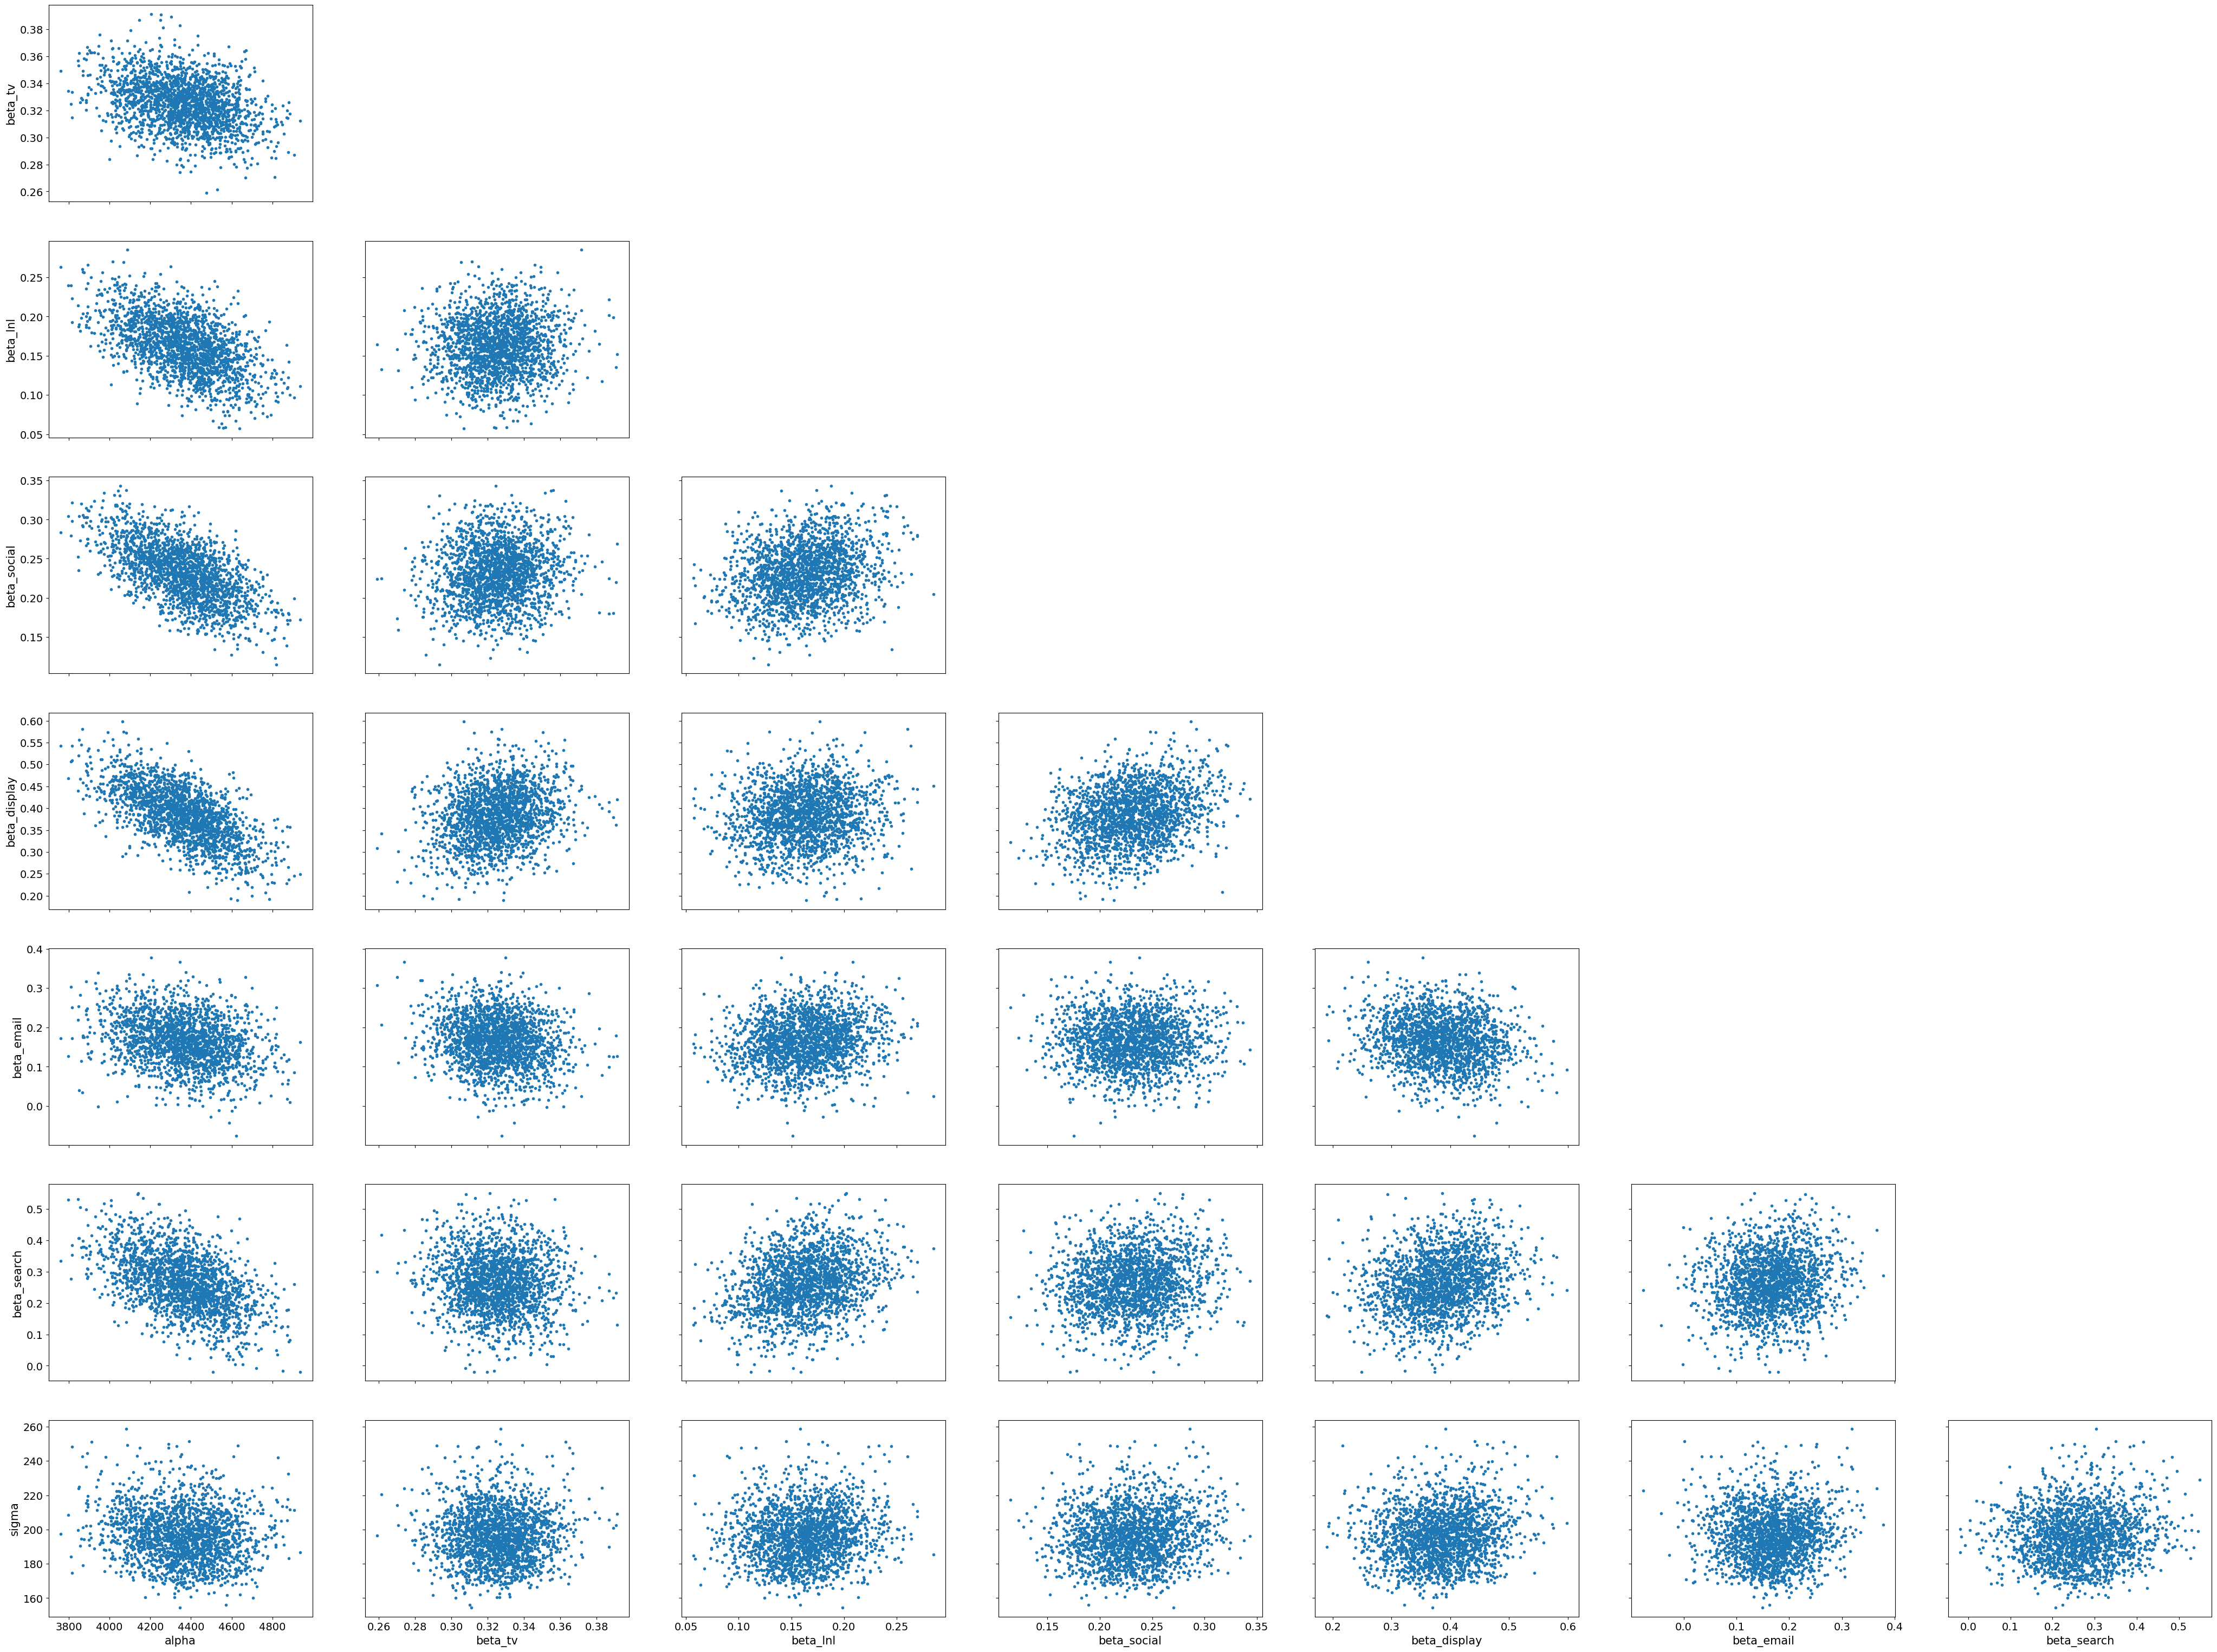

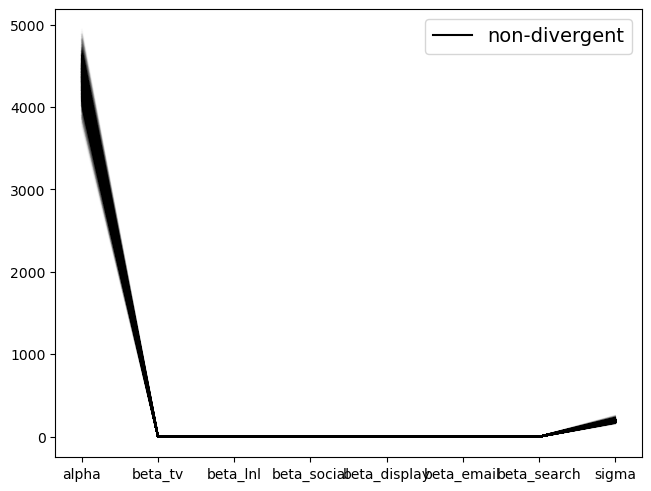

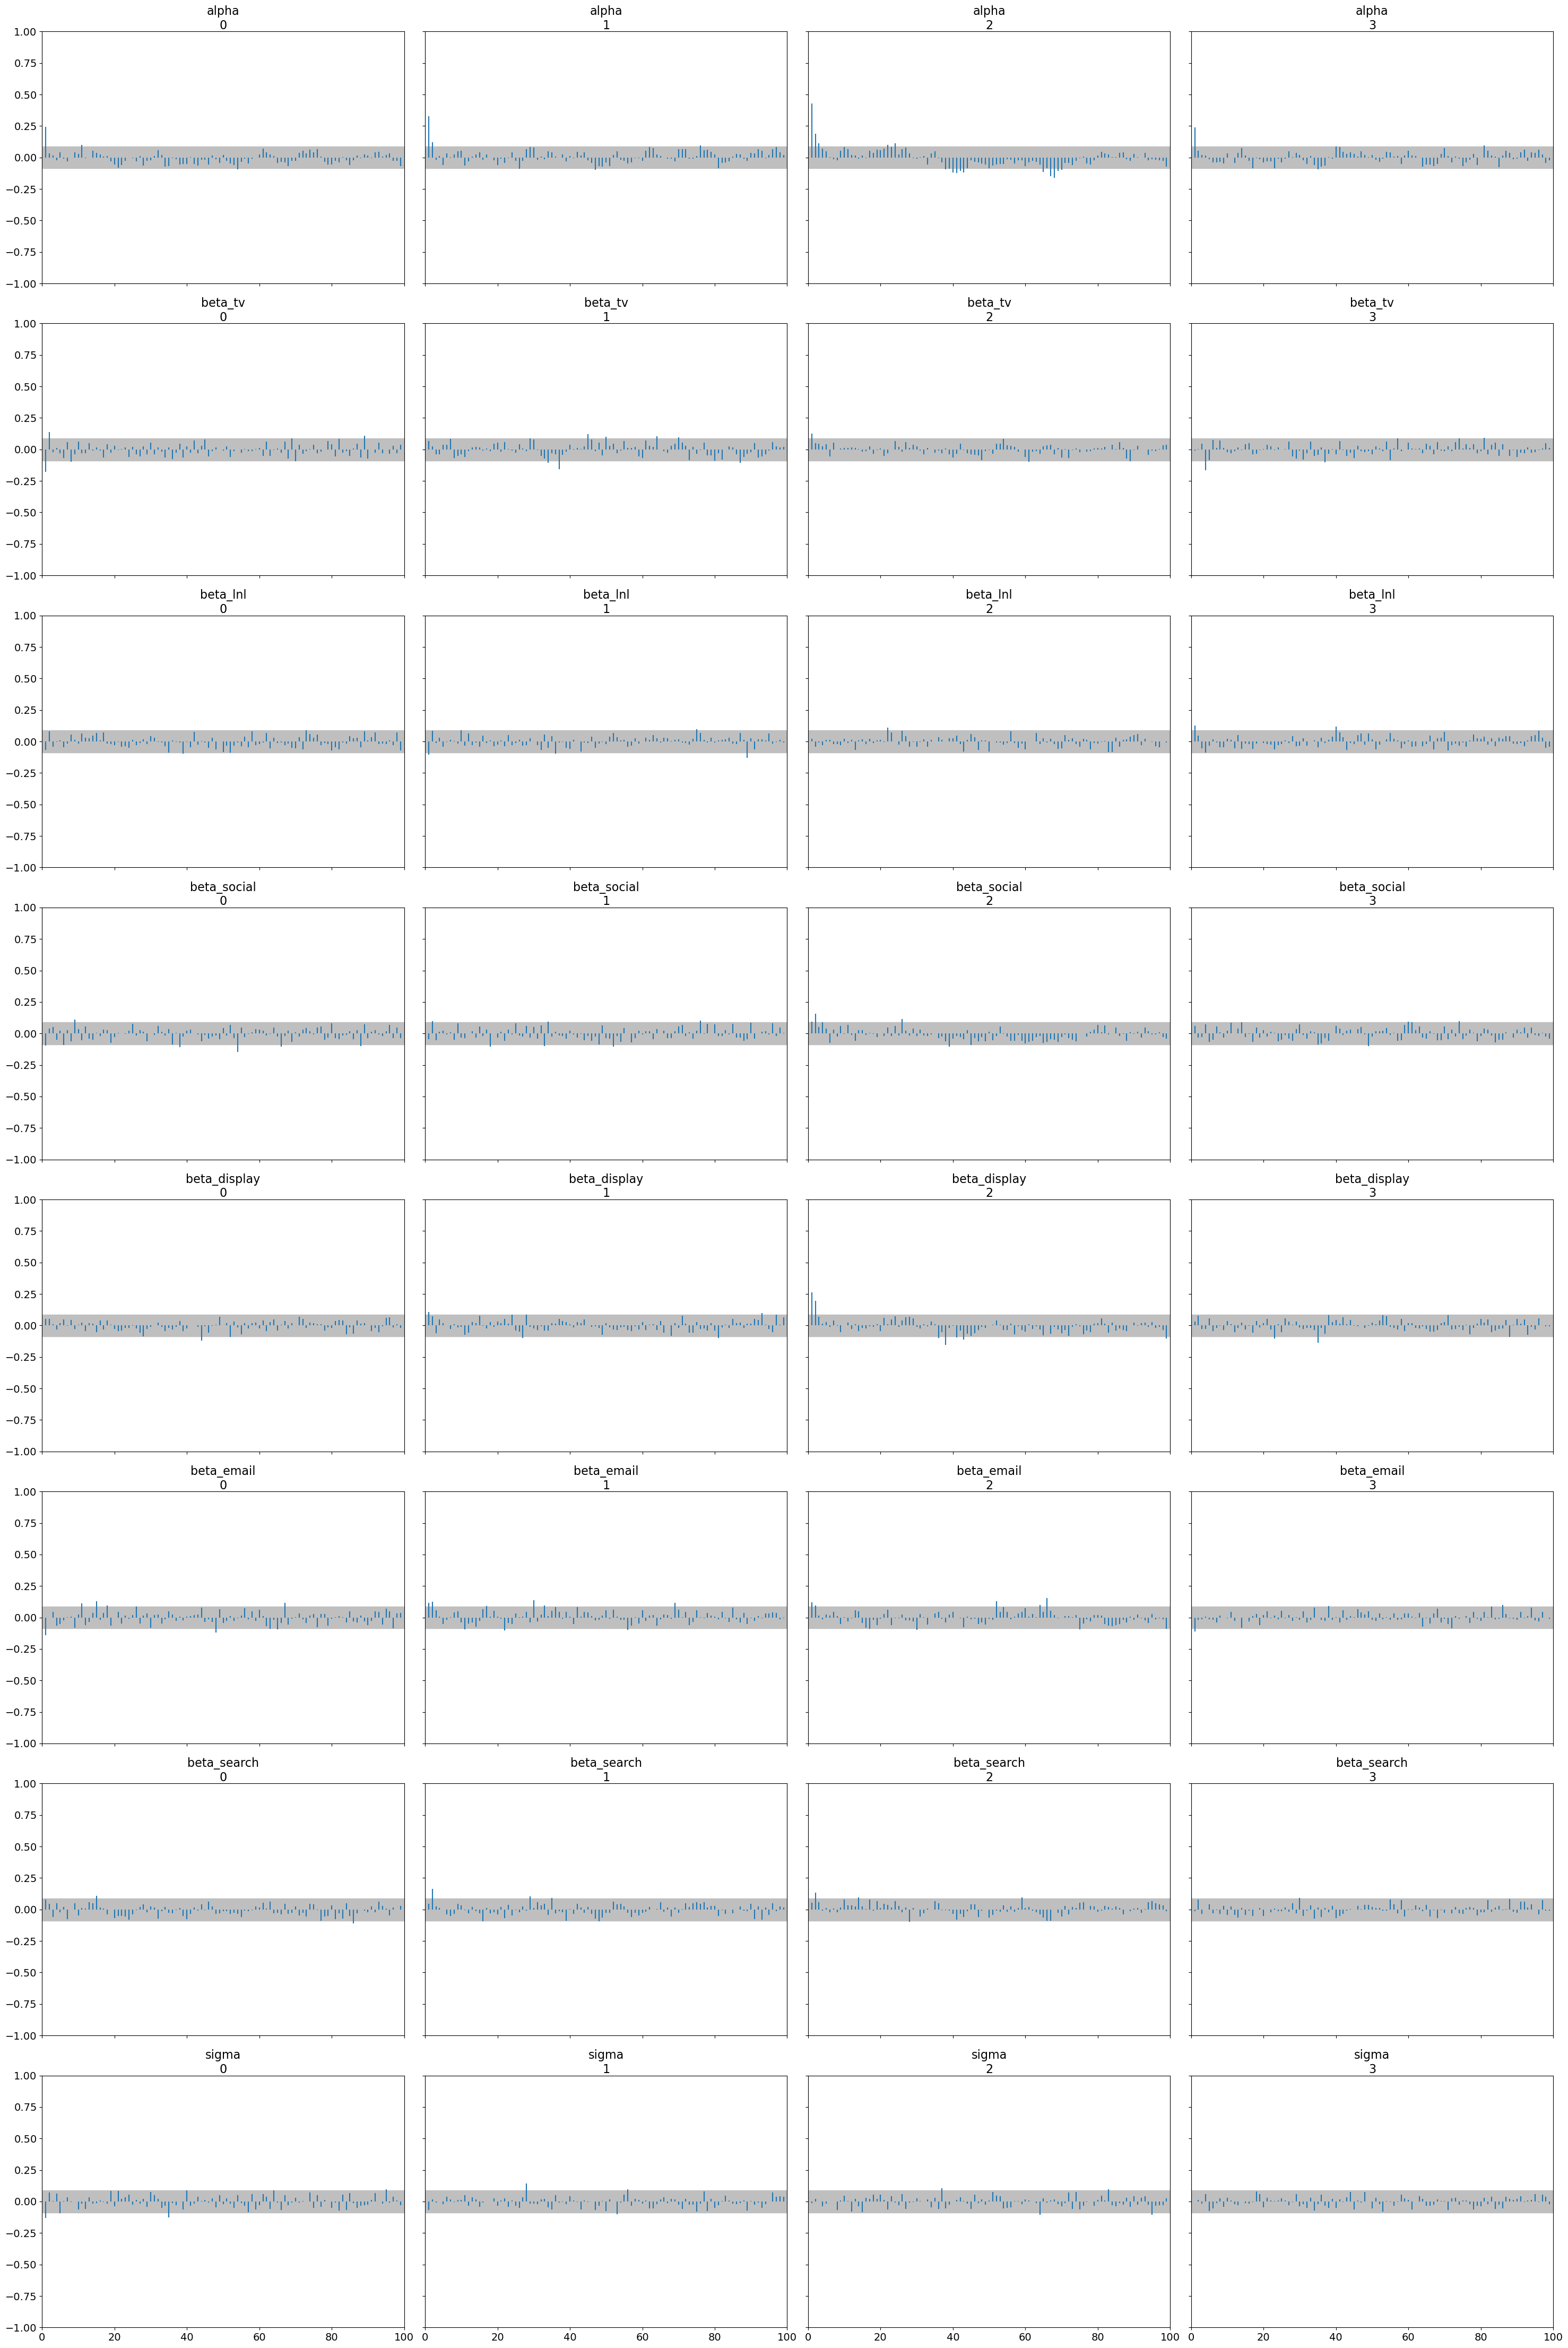

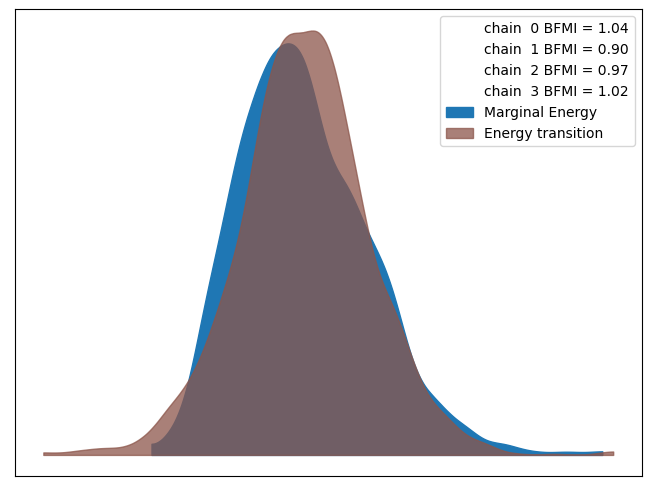

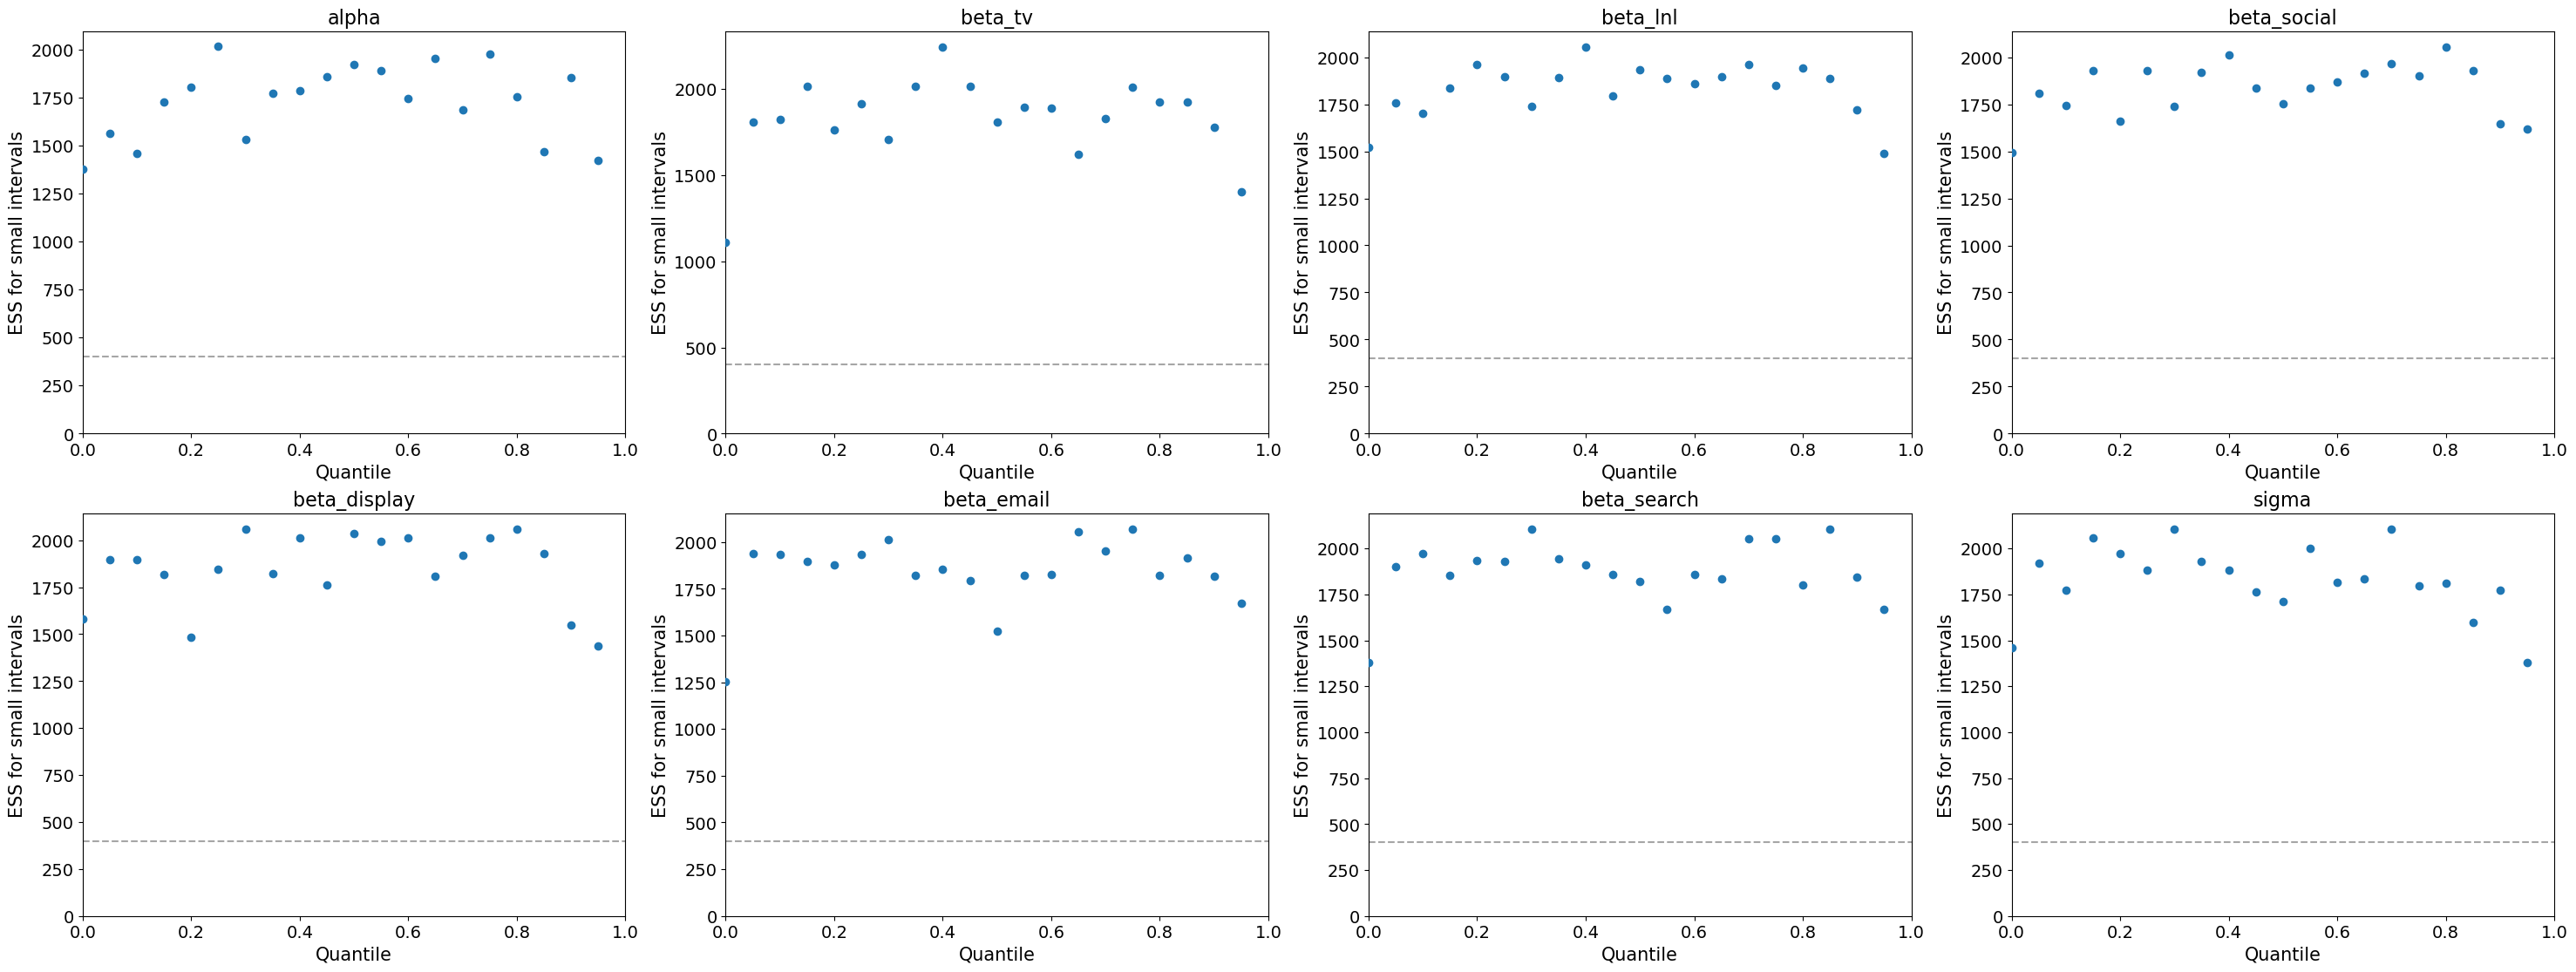

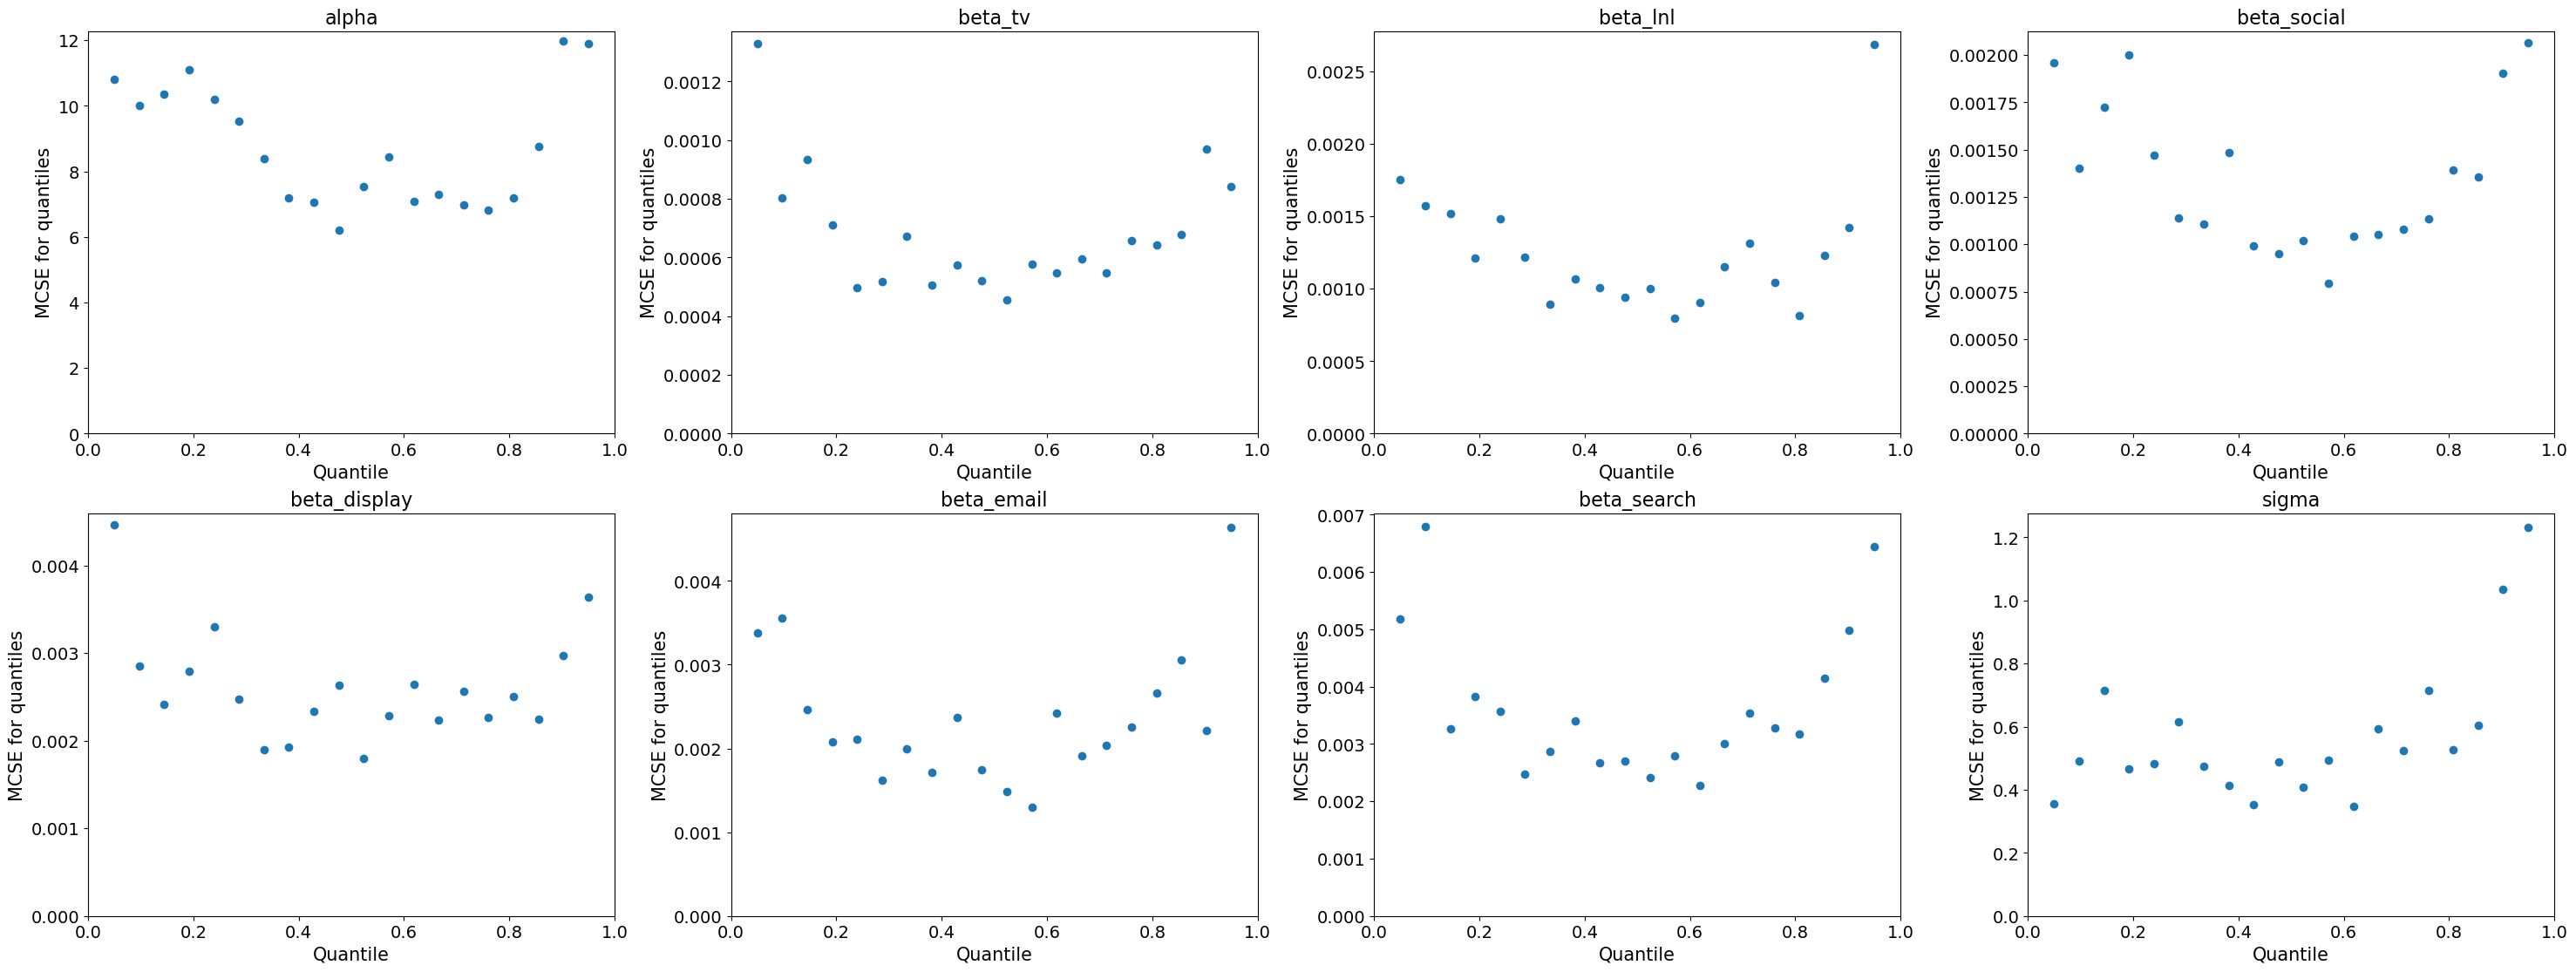

In [10]:

az.plot_trace(fit)
az.plot_posterior(fit)

az.plot_forest(fit)
az.plot_density(fit)
az.plot_pair(fit)
az.plot_parallel(fit)
az.plot_autocorr(fit)
az.plot_energy(fit)
az.plot_ess(fit)
az.plot_mcse(fit)
az.plot_rank(fit)
az.plot_neff(fit)
az.plot_rhat(fit)
az.plot_loo_pit(fit)
az.plot_khat(fit)
az.plot_ppc(fit)
az.plot_violin(fit)
az.plot_hdi(fit)
az.plot_ecdf(fit)
az.plot_dist(fit)





# 2) PYMC3 

In [10]:
import pymc3 as pm
import arviz as az
import pandas as pd
import numpy as np
import pickle
import os
import time
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
   
from memory_profiler import memory_usage

In [4]:
biggest_number = 1000
seed = 42
iter_sampling = 1000
iter_warmup = 1000
chains = 4
thin = 1
adapt_delta = 0.95
max_treedepth = 15

records = []

pymc3_file_path = './time_outputs/pymc3.csv'

## TIME

In [6]:

# for seed in [42]:
#   for N in [100]:
for seed in np.random.randint(1, 10000, size=10):
  for N in np.linspace(100, biggest_number, 10):
    df = pd.read_csv(f'./synthetic_data/marketing_data_samples_{int(N)}.csv')

    with pm.Model() as marketing_mix_model:
        # Priors
        alpha = pm.Normal('alpha', mu=0, sd=1000)
        beta_tv = pm.Normal('beta_tv', mu=0, sd=1000)
        beta_lnl = pm.Normal('beta_lnl', mu=0, sd=1000)
        beta_social = pm.Normal('beta_social', mu=0, sd=1000)
        beta_display = pm.Normal('beta_display', mu=0, sd=1000)
        beta_email = pm.Normal('beta_email', mu=0, sd=1000)
        beta_search = pm.Normal('beta_search', mu=0, sd=1000)
        sigma = pm.HalfNormal('sigma', sd=1000)
        
        
        sales = (alpha +
                          beta_tv * df['tv'].values +
                          beta_lnl * df['lnl'].values +
                          beta_social * df['social'].values +
                          beta_display * df['display'].values +
                          beta_email * df['email'].values +
                          beta_search * df['search'].values)
        

        sales_obs = pm.Normal('sales_obs', mu=sales, sd=sigma, observed=df['sales'].values)

        start_time = time.time()
          
        trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
        
        fit_time = time.time() - start_time
        
        now = datetime.now() 
        
        record = {
              'seed': int(seed),
              'date': now.strftime('%y%m%d'),
              'seed-date': now.strftime('%y%m%d') + '-' + str(int(seed)),
              'time': now.strftime('%y%m%d%H%M'),
              'model' :'PYMC3',
              'N' : len(df),
              'results_summary' : pm.summary(trace),
              'diagnose' : '--',
              'fit_time' : fit_time, 
              }
        
        records.append(record)

        # Saving the model
        model_file_name = './pymc3_outputs/pymc3_model_'+now.strftime('%y%m%d%H%M')+ '-' + str(int(seed))+'.pkl'
        with open(model_file_name, 'wb') as buff:
            pickle.dump({'model': marketing_mix_model, 'trace': trace}, buff)
        print(f'Model saved to {model_file_name}')

        # Saving the trace (model output) using ArviZ's to_netcdf function
        output_file_name = './pymc3_outputs/model_trace'+now.strftime('%y%m%d%H%M')+ '-' + str(int(seed))+'.nc'
        az.to_netcdf(az.from_pymc3(trace), output_file_name)
        print(f'Trace saved to {output_file_name}')

        # Saving the summary
        summary = az.summary(az.from_pymc3(trace))
        summary_file_name = './pymc3_outputs/model_summary'+now.strftime('%y%m%d%H%M')+ '-' + str(int(seed))+'.csv'
        summary.to_csv(summary_file_name)
        print(f'Summary saved to {summary_file_name}')

# Check if the CSV file exists
if os.path.exists(pymc3_file_path):
    # Read the existing CSV file
    df_existing = pd.read_csv(pymc3_file_path)
    
    # Convert the list of new records into a DataFrame
    df_new_records = pd.DataFrame(records)
    
    # Append the new records to the existing DataFrame
    df_updated = pd.concat([df_existing, df_new_records], ignore_index=True)
else:
    # If the file does not exist, create a DataFrame from the new records
    df_updated = pd.DataFrame(records)

# Save the updated DataFrame to a CSV file
df_updated.to_csv(pymc3_file_path, index=False)
 

/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221254-3156.pkl
Trace saved to ./pymc3_outputs/model_trace2402221254-3156.nc
Summary saved to ./pymc3_outputs/model_summary2402221254-3156.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221254-3156.pkl
Trace saved to ./pymc3_outputs/model_trace2402221254-3156.nc
Summary saved to ./pymc3_outputs/model_summary2402221254-3156.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221255-3156.pkl
Trace saved to ./pymc3_outputs/model_trace2402221255-3156.nc
Summary saved to ./pymc3_outputs/model_summary2402221255-3156.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221256-3156.pkl
Trace saved to ./pymc3_outputs/model_trace2402221256-3156.nc
Summary saved to ./pymc3_outputs/model_summary2402221256-3156.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221257-3156.pkl
Trace saved to ./pymc3_outputs/model_trace2402221257-3156.nc
Summary saved to ./pymc3_outputs/model_summary2402221257-3156.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221258-3156.pkl
Trace saved to ./pymc3_outputs/model_trace2402221258-3156.nc
Summary saved to ./pymc3_outputs/model_summary2402221258-3156.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221259-3156.pkl
Trace saved to ./pymc3_outputs/model_trace2402221259-3156.nc
Summary saved to ./pymc3_outputs/model_summary2402221259-3156.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221300-3156.pkl
Trace saved to ./pymc3_outputs/model_trace2402221300-3156.nc
Summary saved to ./pymc3_outputs/model_summary2402221300-3156.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221302-3156.pkl
Trace saved to ./pymc3_outputs/model_trace2402221302-3156.nc
Summary saved to ./pymc3_outputs/model_summary2402221302-3156.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221303-3156.pkl
Trace saved to ./pymc3_outputs/model_trace2402221303-3156.nc
Summary saved to ./pymc3_outputs/model_summary2402221303-3156.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221304-6117.pkl
Trace saved to ./pymc3_outputs/model_trace2402221304-6117.nc
Summary saved to ./pymc3_outputs/model_summary2402221304-6117.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221305-6117.pkl
Trace saved to ./pymc3_outputs/model_trace2402221305-6117.nc
Summary saved to ./pymc3_outputs/model_summary2402221305-6117.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221306-6117.pkl
Trace saved to ./pymc3_outputs/model_trace2402221306-6117.nc
Summary saved to ./pymc3_outputs/model_summary2402221306-6117.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221306-6117.pkl
Trace saved to ./pymc3_outputs/model_trace2402221306-6117.nc
Summary saved to ./pymc3_outputs/model_summary2402221306-6117.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221307-6117.pkl
Trace saved to ./pymc3_outputs/model_trace2402221307-6117.nc
Summary saved to ./pymc3_outputs/model_summary2402221307-6117.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221308-6117.pkl
Trace saved to ./pymc3_outputs/model_trace2402221308-6117.nc
Summary saved to ./pymc3_outputs/model_summary2402221308-6117.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221309-6117.pkl
Trace saved to ./pymc3_outputs/model_trace2402221309-6117.nc
Summary saved to ./pymc3_outputs/model_summary2402221309-6117.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221310-6117.pkl
Trace saved to ./pymc3_outputs/model_trace2402221310-6117.nc
Summary saved to ./pymc3_outputs/model_summary2402221310-6117.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221311-6117.pkl
Trace saved to ./pymc3_outputs/model_trace2402221311-6117.nc
Summary saved to ./pymc3_outputs/model_summary2402221311-6117.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221312-6117.pkl
Trace saved to ./pymc3_outputs/model_trace2402221312-6117.nc
Summary saved to ./pymc3_outputs/model_summary2402221312-6117.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221313-9340.pkl
Trace saved to ./pymc3_outputs/model_trace2402221313-9340.nc
Summary saved to ./pymc3_outputs/model_summary2402221313-9340.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221314-9340.pkl
Trace saved to ./pymc3_outputs/model_trace2402221314-9340.nc
Summary saved to ./pymc3_outputs/model_summary2402221314-9340.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221315-9340.pkl
Trace saved to ./pymc3_outputs/model_trace2402221315-9340.nc
Summary saved to ./pymc3_outputs/model_summary2402221315-9340.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221316-9340.pkl
Trace saved to ./pymc3_outputs/model_trace2402221316-9340.nc
Summary saved to ./pymc3_outputs/model_summary2402221316-9340.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221317-9340.pkl
Trace saved to ./pymc3_outputs/model_trace2402221317-9340.nc
Summary saved to ./pymc3_outputs/model_summary2402221317-9340.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221318-9340.pkl
Trace saved to ./pymc3_outputs/model_trace2402221318-9340.nc
Summary saved to ./pymc3_outputs/model_summary2402221318-9340.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221319-9340.pkl
Trace saved to ./pymc3_outputs/model_trace2402221319-9340.nc
Summary saved to ./pymc3_outputs/model_summary2402221319-9340.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221320-9340.pkl
Trace saved to ./pymc3_outputs/model_trace2402221320-9340.nc
Summary saved to ./pymc3_outputs/model_summary2402221320-9340.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221321-9340.pkl
Trace saved to ./pymc3_outputs/model_trace2402221321-9340.nc
Summary saved to ./pymc3_outputs/model_summary2402221321-9340.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221322-9340.pkl
Trace saved to ./pymc3_outputs/model_trace2402221322-9340.nc
Summary saved to ./pymc3_outputs/model_summary2402221322-9340.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221323-3313.pkl
Trace saved to ./pymc3_outputs/model_trace2402221323-3313.nc
Summary saved to ./pymc3_outputs/model_summary2402221323-3313.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221324-3313.pkl
Trace saved to ./pymc3_outputs/model_trace2402221324-3313.nc
Summary saved to ./pymc3_outputs/model_summary2402221324-3313.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221325-3313.pkl
Trace saved to ./pymc3_outputs/model_trace2402221325-3313.nc
Summary saved to ./pymc3_outputs/model_summary2402221325-3313.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221326-3313.pkl
Trace saved to ./pymc3_outputs/model_trace2402221326-3313.nc
Summary saved to ./pymc3_outputs/model_summary2402221326-3313.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221327-3313.pkl
Trace saved to ./pymc3_outputs/model_trace2402221327-3313.nc
Summary saved to ./pymc3_outputs/model_summary2402221327-3313.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221328-3313.pkl
Trace saved to ./pymc3_outputs/model_trace2402221328-3313.nc
Summary saved to ./pymc3_outputs/model_summary2402221328-3313.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221329-3313.pkl
Trace saved to ./pymc3_outputs/model_trace2402221329-3313.nc
Summary saved to ./pymc3_outputs/model_summary2402221329-3313.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221330-3313.pkl
Trace saved to ./pymc3_outputs/model_trace2402221330-3313.nc
Summary saved to ./pymc3_outputs/model_summary2402221330-3313.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221331-3313.pkl
Trace saved to ./pymc3_outputs/model_trace2402221331-3313.nc
Summary saved to ./pymc3_outputs/model_summary2402221331-3313.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221332-3313.pkl
Trace saved to ./pymc3_outputs/model_trace2402221332-3313.nc
Summary saved to ./pymc3_outputs/model_summary2402221332-3313.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221333-6599.pkl
Trace saved to ./pymc3_outputs/model_trace2402221333-6599.nc
Summary saved to ./pymc3_outputs/model_summary2402221333-6599.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221334-6599.pkl
Trace saved to ./pymc3_outputs/model_trace2402221334-6599.nc
Summary saved to ./pymc3_outputs/model_summary2402221334-6599.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221335-6599.pkl
Trace saved to ./pymc3_outputs/model_trace2402221335-6599.nc
Summary saved to ./pymc3_outputs/model_summary2402221335-6599.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221335-6599.pkl
Trace saved to ./pymc3_outputs/model_trace2402221335-6599.nc
Summary saved to ./pymc3_outputs/model_summary2402221335-6599.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221336-6599.pkl
Trace saved to ./pymc3_outputs/model_trace2402221336-6599.nc
Summary saved to ./pymc3_outputs/model_summary2402221336-6599.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221337-6599.pkl
Trace saved to ./pymc3_outputs/model_trace2402221337-6599.nc
Summary saved to ./pymc3_outputs/model_summary2402221337-6599.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221338-6599.pkl
Trace saved to ./pymc3_outputs/model_trace2402221338-6599.nc
Summary saved to ./pymc3_outputs/model_summary2402221338-6599.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221339-6599.pkl
Trace saved to ./pymc3_outputs/model_trace2402221339-6599.nc
Summary saved to ./pymc3_outputs/model_summary2402221339-6599.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221340-6599.pkl
Trace saved to ./pymc3_outputs/model_trace2402221340-6599.nc
Summary saved to ./pymc3_outputs/model_summary2402221340-6599.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221341-6599.pkl
Trace saved to ./pymc3_outputs/model_trace2402221341-6599.nc
Summary saved to ./pymc3_outputs/model_summary2402221341-6599.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221342-4308.pkl
Trace saved to ./pymc3_outputs/model_trace2402221342-4308.nc
Summary saved to ./pymc3_outputs/model_summary2402221342-4308.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221343-4308.pkl
Trace saved to ./pymc3_outputs/model_trace2402221343-4308.nc
Summary saved to ./pymc3_outputs/model_summary2402221343-4308.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221344-4308.pkl
Trace saved to ./pymc3_outputs/model_trace2402221344-4308.nc
Summary saved to ./pymc3_outputs/model_summary2402221344-4308.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221344-4308.pkl
Trace saved to ./pymc3_outputs/model_trace2402221344-4308.nc
Summary saved to ./pymc3_outputs/model_summary2402221344-4308.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221345-4308.pkl
Trace saved to ./pymc3_outputs/model_trace2402221345-4308.nc
Summary saved to ./pymc3_outputs/model_summary2402221345-4308.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221346-4308.pkl
Trace saved to ./pymc3_outputs/model_trace2402221346-4308.nc
Summary saved to ./pymc3_outputs/model_summary2402221346-4308.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221347-4308.pkl
Trace saved to ./pymc3_outputs/model_trace2402221347-4308.nc
Summary saved to ./pymc3_outputs/model_summary2402221347-4308.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221348-4308.pkl
Trace saved to ./pymc3_outputs/model_trace2402221348-4308.nc
Summary saved to ./pymc3_outputs/model_summary2402221348-4308.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221349-4308.pkl
Trace saved to ./pymc3_outputs/model_trace2402221349-4308.nc
Summary saved to ./pymc3_outputs/model_summary2402221349-4308.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221350-4308.pkl
Trace saved to ./pymc3_outputs/model_trace2402221350-4308.nc
Summary saved to ./pymc3_outputs/model_summary2402221350-4308.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221351-8057.pkl
Trace saved to ./pymc3_outputs/model_trace2402221351-8057.nc
Summary saved to ./pymc3_outputs/model_summary2402221351-8057.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221352-8057.pkl
Trace saved to ./pymc3_outputs/model_trace2402221352-8057.nc
Summary saved to ./pymc3_outputs/model_summary2402221352-8057.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221353-8057.pkl
Trace saved to ./pymc3_outputs/model_trace2402221353-8057.nc
Summary saved to ./pymc3_outputs/model_summary2402221353-8057.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221354-8057.pkl
Trace saved to ./pymc3_outputs/model_trace2402221354-8057.nc
Summary saved to ./pymc3_outputs/model_summary2402221354-8057.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221355-8057.pkl
Trace saved to ./pymc3_outputs/model_trace2402221355-8057.nc
Summary saved to ./pymc3_outputs/model_summary2402221355-8057.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221356-8057.pkl
Trace saved to ./pymc3_outputs/model_trace2402221356-8057.nc
Summary saved to ./pymc3_outputs/model_summary2402221356-8057.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221357-8057.pkl
Trace saved to ./pymc3_outputs/model_trace2402221357-8057.nc
Summary saved to ./pymc3_outputs/model_summary2402221357-8057.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221358-8057.pkl
Trace saved to ./pymc3_outputs/model_trace2402221358-8057.nc
Summary saved to ./pymc3_outputs/model_summary2402221358-8057.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221359-8057.pkl
Trace saved to ./pymc3_outputs/model_trace2402221359-8057.nc
Summary saved to ./pymc3_outputs/model_summary2402221359-8057.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221400-8057.pkl
Trace saved to ./pymc3_outputs/model_trace2402221400-8057.nc
Summary saved to ./pymc3_outputs/model_summary2402221400-8057.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221401-839.pkl
Trace saved to ./pymc3_outputs/model_trace2402221401-839.nc
Summary saved to ./pymc3_outputs/model_summary2402221401-839.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221402-839.pkl
Trace saved to ./pymc3_outputs/model_trace2402221402-839.nc
Summary saved to ./pymc3_outputs/model_summary2402221402-839.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221403-839.pkl
Trace saved to ./pymc3_outputs/model_trace2402221403-839.nc
Summary saved to ./pymc3_outputs/model_summary2402221403-839.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221404-839.pkl
Trace saved to ./pymc3_outputs/model_trace2402221404-839.nc
Summary saved to ./pymc3_outputs/model_summary2402221404-839.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221405-839.pkl
Trace saved to ./pymc3_outputs/model_trace2402221405-839.nc
Summary saved to ./pymc3_outputs/model_summary2402221405-839.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221406-839.pkl
Trace saved to ./pymc3_outputs/model_trace2402221406-839.nc
Summary saved to ./pymc3_outputs/model_summary2402221406-839.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221407-839.pkl
Trace saved to ./pymc3_outputs/model_trace2402221407-839.nc
Summary saved to ./pymc3_outputs/model_summary2402221407-839.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221408-839.pkl
Trace saved to ./pymc3_outputs/model_trace2402221408-839.nc
Summary saved to ./pymc3_outputs/model_summary2402221408-839.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221409-839.pkl
Trace saved to ./pymc3_outputs/model_trace2402221409-839.nc
Summary saved to ./pymc3_outputs/model_summary2402221409-839.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221410-839.pkl
Trace saved to ./pymc3_outputs/model_trace2402221410-839.nc
Summary saved to ./pymc3_outputs/model_summary2402221410-839.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221411-4706.pkl
Trace saved to ./pymc3_outputs/model_trace2402221411-4706.nc
Summary saved to ./pymc3_outputs/model_summary2402221411-4706.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221411-4706.pkl
Trace saved to ./pymc3_outputs/model_trace2402221411-4706.nc
Summary saved to ./pymc3_outputs/model_summary2402221411-4706.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221412-4706.pkl
Trace saved to ./pymc3_outputs/model_trace2402221412-4706.nc
Summary saved to ./pymc3_outputs/model_summary2402221412-4706.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221413-4706.pkl
Trace saved to ./pymc3_outputs/model_trace2402221413-4706.nc
Summary saved to ./pymc3_outputs/model_summary2402221413-4706.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221414-4706.pkl
Trace saved to ./pymc3_outputs/model_trace2402221414-4706.nc
Summary saved to ./pymc3_outputs/model_summary2402221414-4706.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221415-4706.pkl
Trace saved to ./pymc3_outputs/model_trace2402221415-4706.nc
Summary saved to ./pymc3_outputs/model_summary2402221415-4706.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221416-4706.pkl
Trace saved to ./pymc3_outputs/model_trace2402221416-4706.nc
Summary saved to ./pymc3_outputs/model_summary2402221416-4706.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221416-4706.pkl
Trace saved to ./pymc3_outputs/model_trace2402221416-4706.nc
Summary saved to ./pymc3_outputs/model_summary2402221416-4706.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221417-4706.pkl
Trace saved to ./pymc3_outputs/model_trace2402221417-4706.nc
Summary saved to ./pymc3_outputs/model_summary2402221417-4706.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221418-4706.pkl
Trace saved to ./pymc3_outputs/model_trace2402221418-4706.nc
Summary saved to ./pymc3_outputs/model_summary2402221418-4706.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221419-462.pkl
Trace saved to ./pymc3_outputs/model_trace2402221419-462.nc
Summary saved to ./pymc3_outputs/model_summary2402221419-462.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221420-462.pkl
Trace saved to ./pymc3_outputs/model_trace2402221420-462.nc
Summary saved to ./pymc3_outputs/model_summary2402221420-462.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221421-462.pkl
Trace saved to ./pymc3_outputs/model_trace2402221421-462.nc
Summary saved to ./pymc3_outputs/model_summary2402221421-462.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221422-462.pkl
Trace saved to ./pymc3_outputs/model_trace2402221422-462.nc
Summary saved to ./pymc3_outputs/model_summary2402221422-462.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221423-462.pkl
Trace saved to ./pymc3_outputs/model_trace2402221423-462.nc
Summary saved to ./pymc3_outputs/model_summary2402221423-462.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221423-462.pkl
Trace saved to ./pymc3_outputs/model_trace2402221423-462.nc
Summary saved to ./pymc3_outputs/model_summary2402221423-462.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221424-462.pkl
Trace saved to ./pymc3_outputs/model_trace2402221424-462.nc
Summary saved to ./pymc3_outputs/model_summary2402221424-462.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221425-462.pkl
Trace saved to ./pymc3_outputs/model_trace2402221425-462.nc
Summary saved to ./pymc3_outputs/model_summary2402221425-462.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221426-462.pkl
Trace saved to ./pymc3_outputs/model_trace2402221426-462.nc
Summary saved to ./pymc3_outputs/model_summary2402221426-462.csv


/tmp/ipykernel_3369375/41694103.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


Model saved to ./pymc3_outputs/pymc3_model_2402221427-462.pkl
Trace saved to ./pymc3_outputs/model_trace2402221427-462.nc
Summary saved to ./pymc3_outputs/model_summary2402221427-462.csv


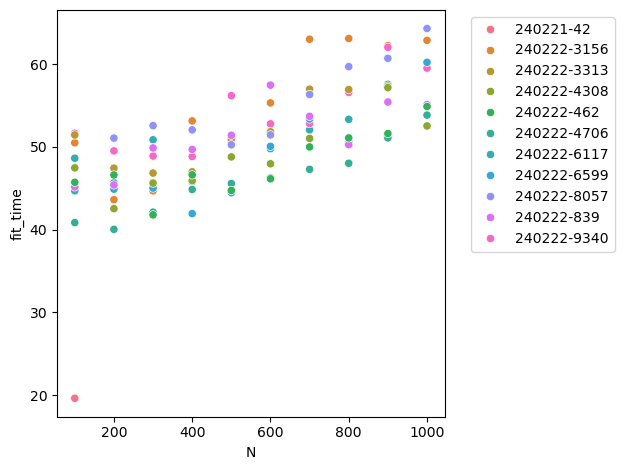

In [11]:
df = pd.read_csv(pymc3_file_path)
df['seed-date'] = pd.Categorical(df['seed-date']) 
sns.scatterplot(data=df, x='N', y='fit_time', hue='seed-date')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust plot to make room for the outside legend
plt.tight_layout()

# Show the plot
plt.show()

## MEMORY

In [30]:
biggest_number = 1000
seed = 42
iter_sampling = 1000
iter_warmup = 1000
chains = 4
thin = 1
adapt_delta = 0.95
max_treedepth = 15

pymc3_memory = './pymc3_outputs/pymc3_memory.csv'

pymc3_memory_trials = []

for seed in np.random.randint(1, 10000, size=3):
    for N in np.linspace(100, 1000, 10):
    
        def run_pymc3_model():

            df = pd.read_csv(f'./synthetic_data/marketing_data_samples_{int(N)}.csv')

            with pm.Model() as marketing_mix_model:
                # Priors
                alpha = pm.Normal('alpha', mu=0, sd=1000)
                beta_tv = pm.Normal('beta_tv', mu=0, sd=1000)
                beta_lnl = pm.Normal('beta_lnl', mu=0, sd=1000)
                beta_social = pm.Normal('beta_social', mu=0, sd=1000)
                beta_display = pm.Normal('beta_display', mu=0, sd=1000)
                beta_email = pm.Normal('beta_email', mu=0, sd=1000)
                beta_search = pm.Normal('beta_search', mu=0, sd=1000)
                sigma = pm.HalfNormal('sigma', sd=1000)

                # Expected value of outcome
                expected_sales = alpha + beta_tv * df['tv'] + beta_lnl * df['lnl'] + beta_social * df['social'] + beta_display * df['display'] + beta_email * df['email'] + beta_search * df['search']

                # Likelihood of observations
                sales_obs = pm.Normal('sales_obs', mu=expected_sales, sd=sigma, observed=df['sales'])

                start_time = time.time()

                # Sample from the posterior
                trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)

                fit_time = time.time() - start_time

            # Optionally, process the trace further here

            return fit_time, len(df)  # Returning the fit time and number of data points

        # Correctly capture the return values from memory_usage
        mem_usage_result = memory_usage((run_pymc3_model), max_usage=True, include_children=True, retval=True)

        # Extract the return value (which is the last element of the list) 
        # and calculate peak memory usage correctly
        fit_time, num_data_points = mem_usage_result[-1]  # This is the correct extraction of return values
        peak_memory = max(mem_usage_result[:-1])  # Calculate peak memory usage excluding the return value

        trial = {
            'seed': seed,
            'date-seed': now.strftime('%y%m%d') + '-' + str(int(seed)),  
            'peak_memory': peak_memory,
            'fit_time': fit_time,
            'N': num_data_points
        }
        print(f"Seed: {seed}, Peak memory usage: {peak_memory} MiB, Fit time: {fit_time} seconds, Data points: {num_data_points}")
        pymc3_memory_trials.append(trial)


pymc3_memory_trials_df = pd.DataFrame(pymc3_memory_trials)
#save to csv but if file exists, append to it
if os.path.exists(pymc3_memory):
    pymc3_memory_trials_df.to_csv(pymc3_memory, mode='a', header=False, index=False)
else:
    pymc3_memory_trials_df.to_csv(pymc3_memory, index=False)
  

/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


Seed: 8756, Peak memory usage: 2349.96875 MiB, Fit time: 51.56769275665283 seconds, Data points: 100


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


Seed: 8756, Peak memory usage: 2427.3359375 MiB, Fit time: 47.178781032562256 seconds, Data points: 200


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


Seed: 8756, Peak memory usage: 2439.44140625 MiB, Fit time: 52.901461362838745 seconds, Data points: 300


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


Seed: 8756, Peak memory usage: 2420.3046875 MiB, Fit time: 48.17838001251221 seconds, Data points: 400


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


Seed: 8756, Peak memory usage: 2394.58203125 MiB, Fit time: 50.85669708251953 seconds, Data points: 500


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


Seed: 8756, Peak memory usage: 2453.4921875 MiB, Fit time: 52.57540726661682 seconds, Data points: 600


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


Seed: 8756, Peak memory usage: 2457.59765625 MiB, Fit time: 56.23438596725464 seconds, Data points: 700


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


Seed: 8756, Peak memory usage: 2456.66015625 MiB, Fit time: 54.77161407470703 seconds, Data points: 800


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


Seed: 8756, Peak memory usage: 2453.26171875 MiB, Fit time: 58.9695463180542 seconds, Data points: 900


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


Seed: 8756, Peak memory usage: 2464.08203125 MiB, Fit time: 58.71532869338989 seconds, Data points: 1000


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


Seed: 6541, Peak memory usage: 2473.96875 MiB, Fit time: 48.49513101577759 seconds, Data points: 100


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


Seed: 6541, Peak memory usage: 2465.609375 MiB, Fit time: 47.9435179233551 seconds, Data points: 200


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


Seed: 6541, Peak memory usage: 2499.046875 MiB, Fit time: 48.87984323501587 seconds, Data points: 300


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


Seed: 6541, Peak memory usage: 2506.99609375 MiB, Fit time: 48.319249629974365 seconds, Data points: 400


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


Seed: 6541, Peak memory usage: 2505.640625 MiB, Fit time: 51.202977418899536 seconds, Data points: 500


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


Seed: 6541, Peak memory usage: 2506.57421875 MiB, Fit time: 51.54294013977051 seconds, Data points: 600


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


Seed: 6541, Peak memory usage: 2506.83203125 MiB, Fit time: 55.52187442779541 seconds, Data points: 700


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


Seed: 6541, Peak memory usage: 2503.1640625 MiB, Fit time: 56.66056442260742 seconds, Data points: 800


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


Seed: 6541, Peak memory usage: 2502.83203125 MiB, Fit time: 58.40231227874756 seconds, Data points: 900


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


Seed: 6541, Peak memory usage: 2503.203125 MiB, Fit time: 62.617613792419434 seconds, Data points: 1000


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


Seed: 810, Peak memory usage: 2501.50390625 MiB, Fit time: 50.382259368896484 seconds, Data points: 100


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


Seed: 810, Peak memory usage: 2502.06640625 MiB, Fit time: 47.81054401397705 seconds, Data points: 200


/tmp/ipykernel_3369375/3351493575.py:41: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_search, beta_email, beta_display, beta_social, beta_lnl, beta_tv, alpha]


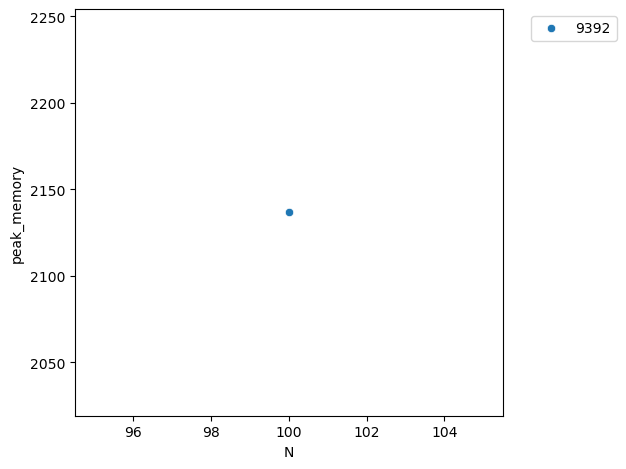

In [ ]:
df = pd.read_csv(pymc3_memory)
df['date-seed'] = pd.Categorical(df['date-seed']) 
sns.scatterplot(data=df, x='N', y='peak_memory', hue='date-seed')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust plot to make room for the outside legend
plt.tight_layout()

# Show the plot
plt.show()

## FITNESS

In [19]:
import pymc3 as pm
import arviz as az
import pickle

# Path to your saved PyMC3 model and trace .pkl file
pkl_file_path = './pymc3_outputs/pymc3_model_2402211639-42.pkl'

# Load the model and trace from the .pkl file
with open(pkl_file_path, 'rb') as file:
    loaded_data = pickle.load(file)
    model = loaded_data['model']
    trace = loaded_data['trace']

# If your posterior predictive samples were not saved with the trace, generate them here
# This step is optional and depends on whether you need to generate new posterior predictive samples
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

# Define dimensions for your variables
dims = {
    "y": ["sales"],
    "x": ["sales"],
    "log_likelihood": ["sales"],
    "y_hat": ["sales"]  # Ensure this matches your posterior predictive variable names
}

# Define idata_kwargs with correct structure for posterior_predictive and log_likelihood
idata_kwargs = {
    # Replace "posterior_predictive" with the actual posterior predictive samples if generated above
    # "posterior_predictive": posterior_predictive, 
    "log_likelihood": "sales_obs",  # Ensure this matches the name used in your model
    "dims": dims,
}

# Create the InferenceData object using the loaded model and trace
with model:
    idata = az.from_pymc3(trace=trace, **idata_kwargs)

# Now, 'idata' contains the structured InferenceData for your loaded PyMC3 model


In [20]:
az.summary(idata, var_names=['beta_tv', 'beta_lnl', 'beta_social', 'beta_display', 'beta_email', 'beta_search'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_tv       0.325  0.017   0.293    0.359      0.000    0.000    1577.0   
beta_lnl      0.162  0.035   0.094    0.227      0.001    0.001    1375.0   
beta_social   0.232  0.034   0.166    0.296      0.001    0.001    1510.0   
beta_display  0.380  0.059   0.270    0.496      0.002    0.001    1370.0   
beta_email    0.167  0.060   0.046    0.274      0.002    0.001    1485.0   
beta_search   0.258  0.087   0.099    0.421      0.002    0.002    1513.0   

              ess_tail  r_hat  
beta_tv         1472.0   1.01  
beta_lnl        1528.0   1.00  
beta_social     1593.0   1.00  
beta_display    1443.0   1.00  
beta_email       775.0   1.00  
beta_search     1540.0   1.00

<Axes: >

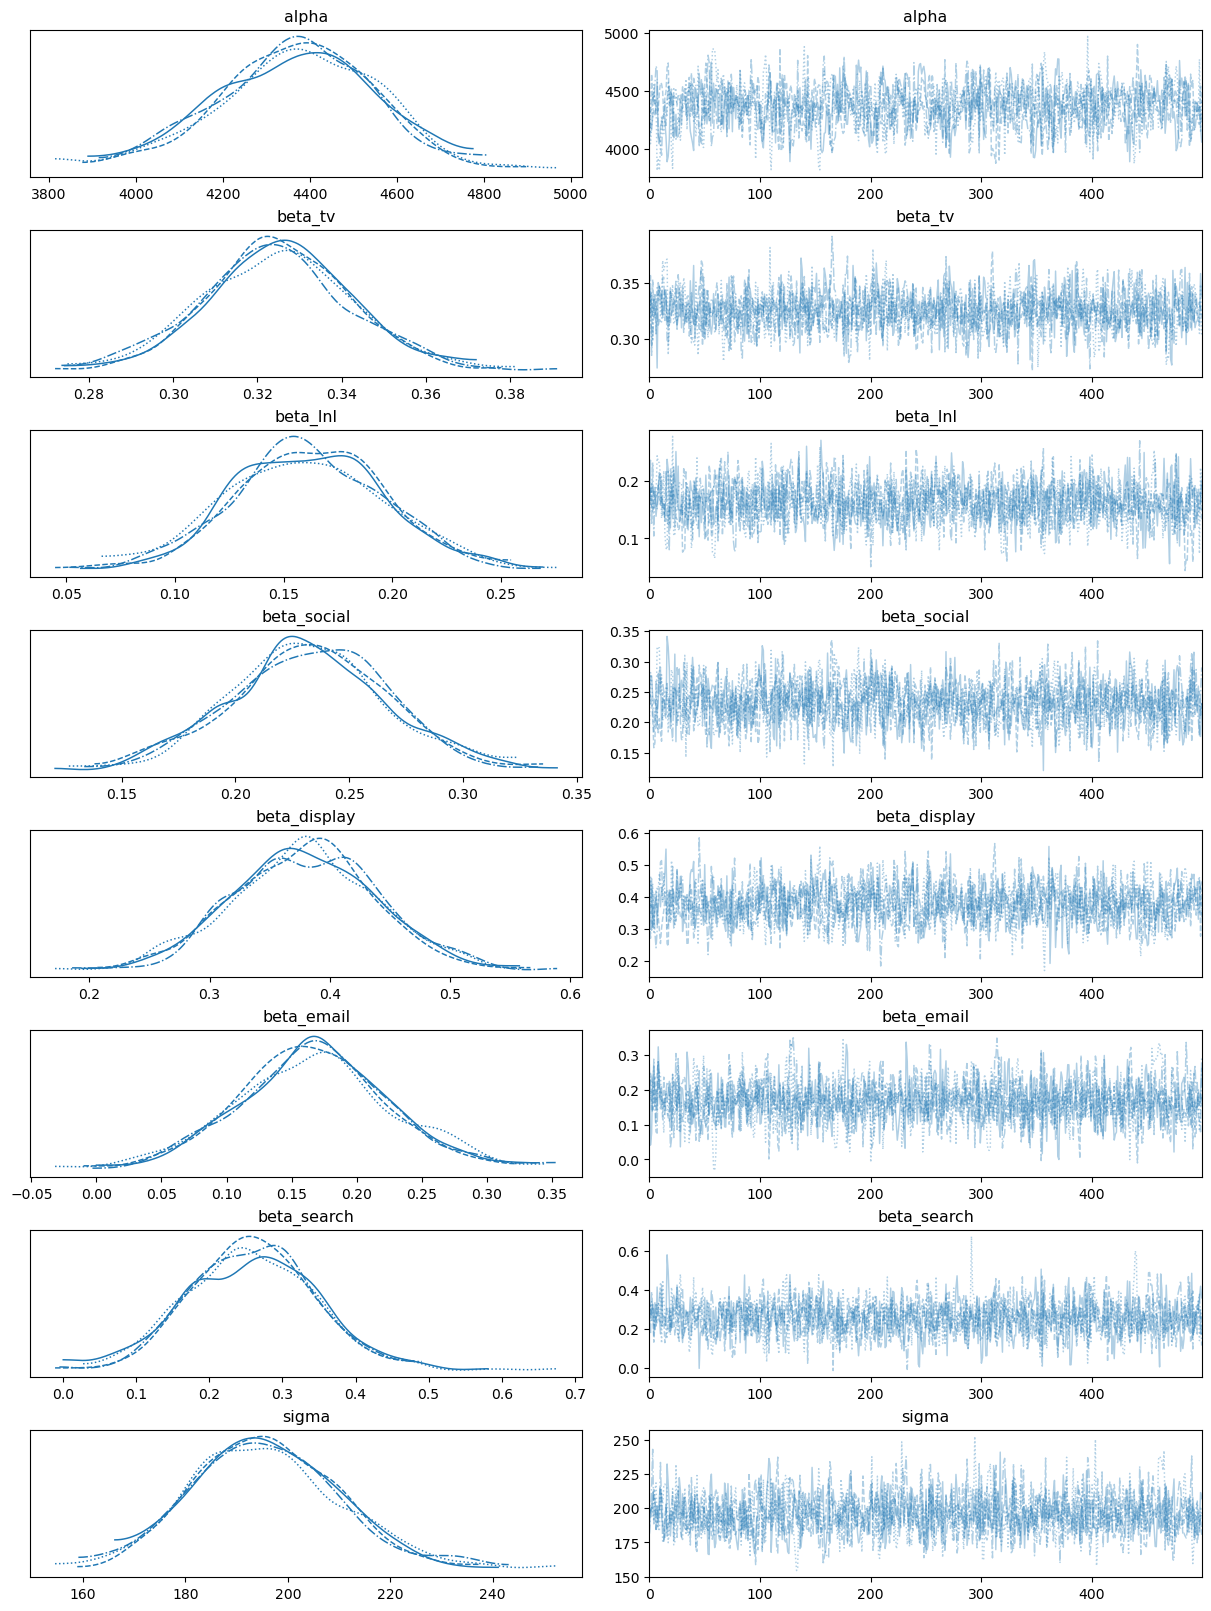

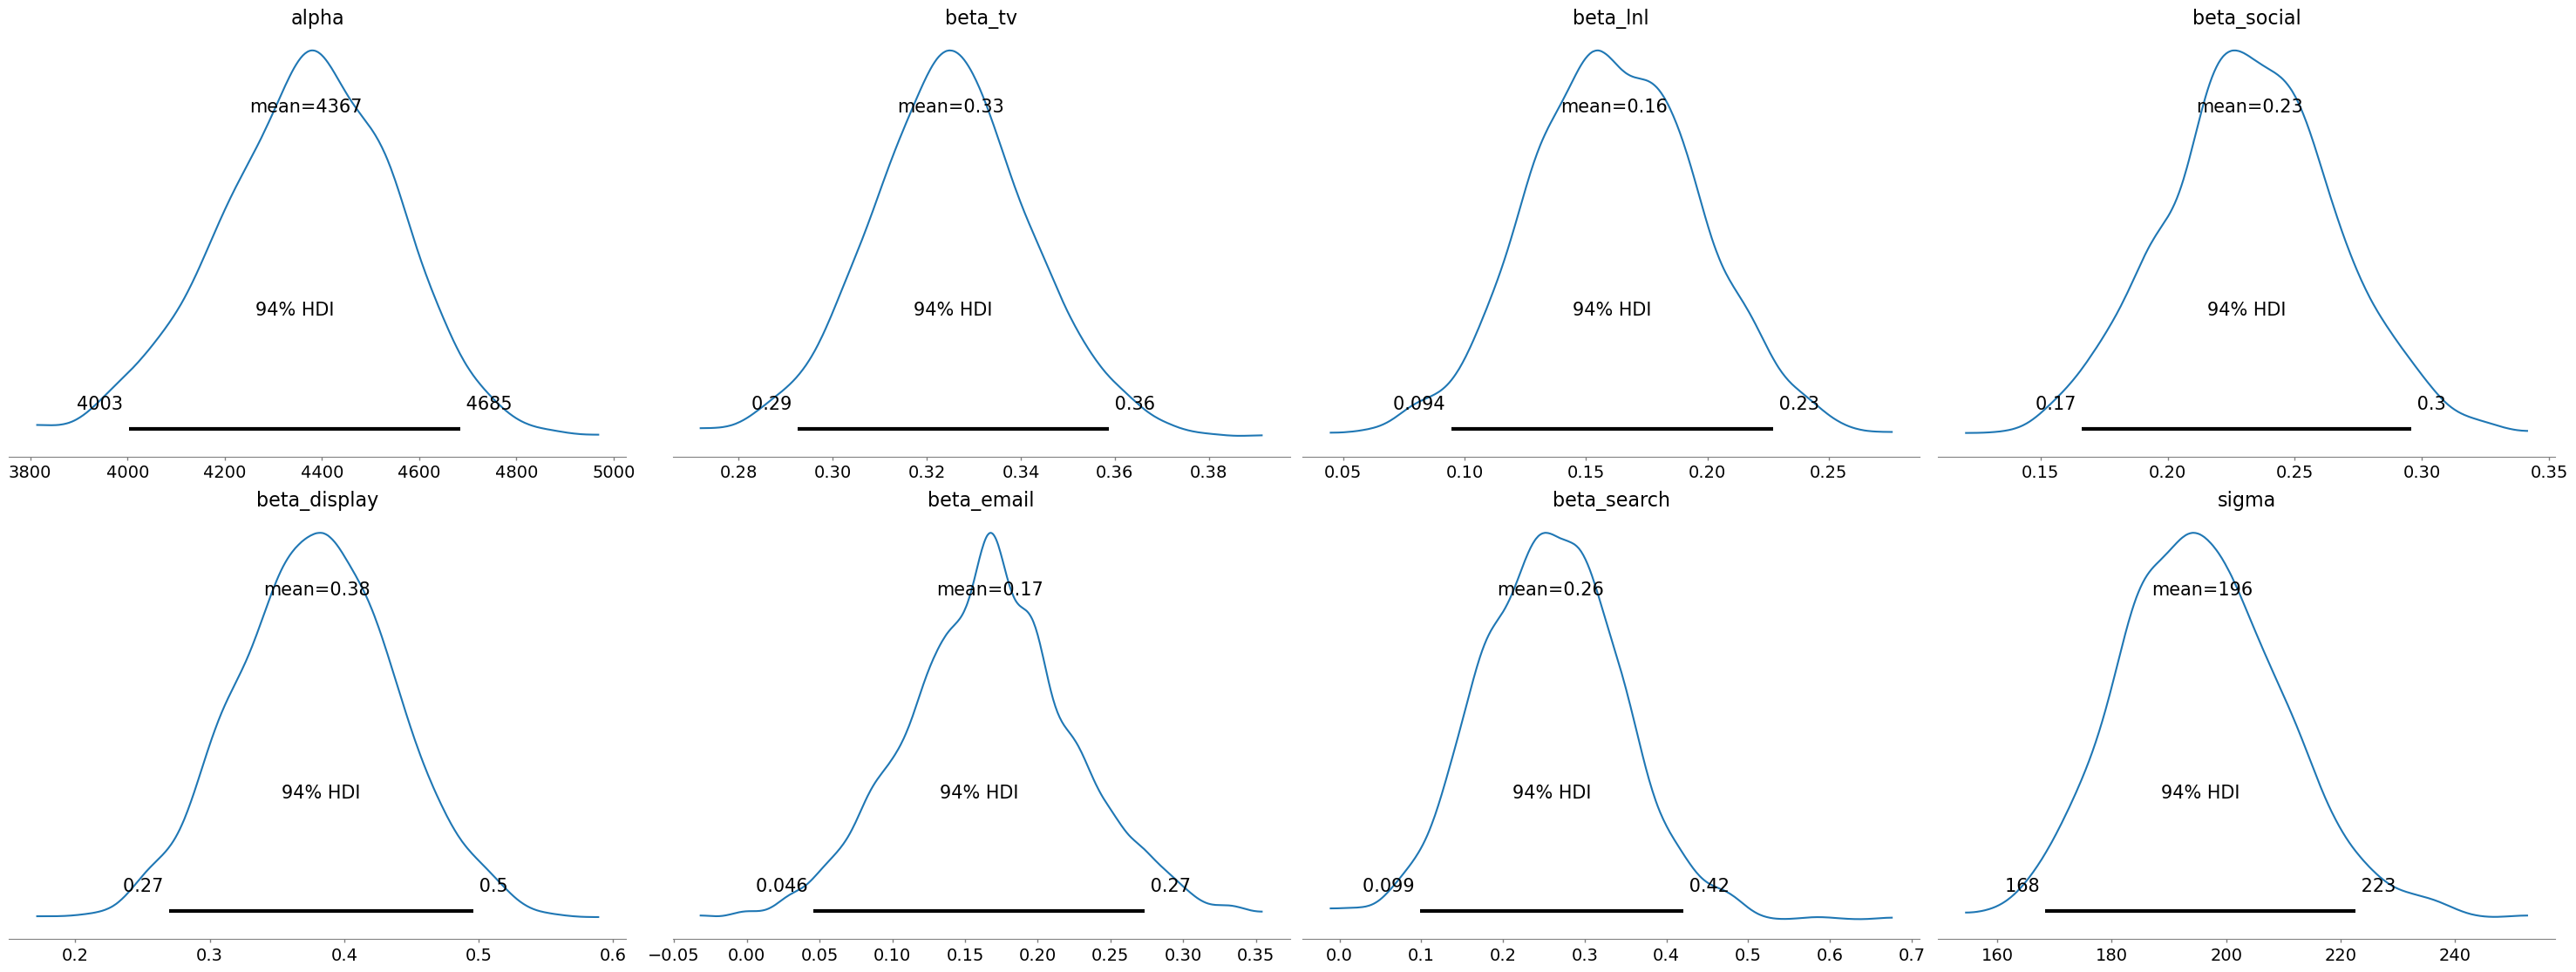

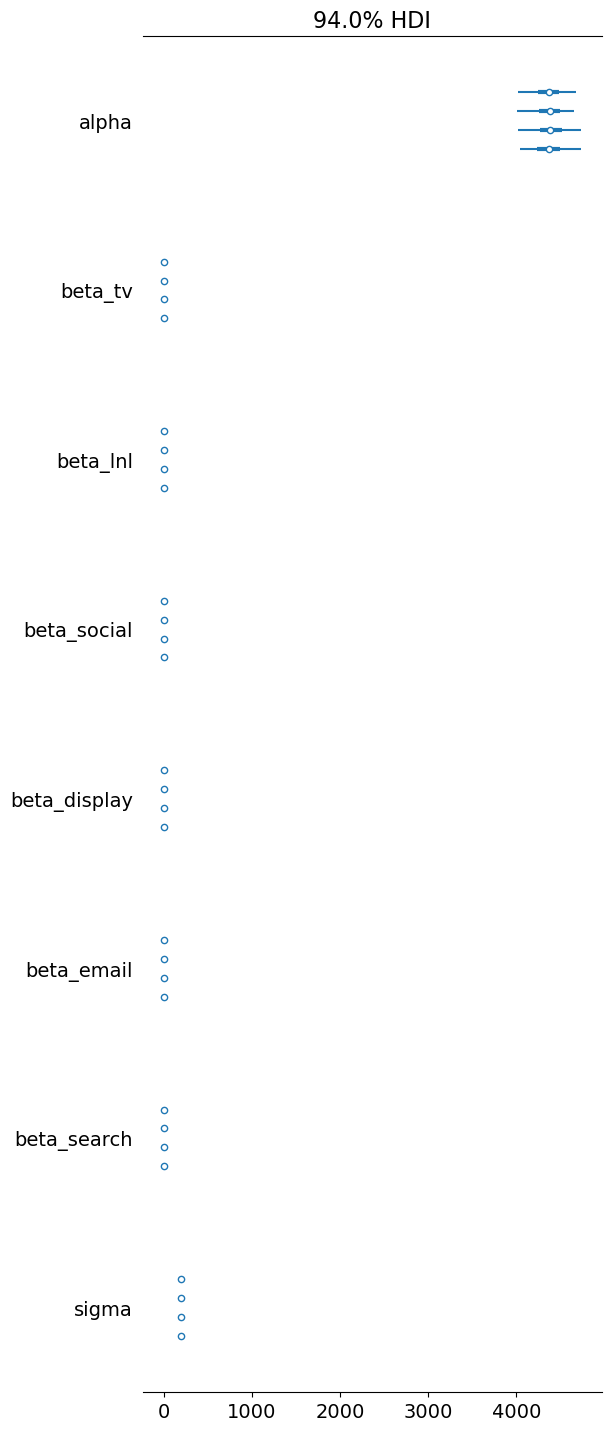

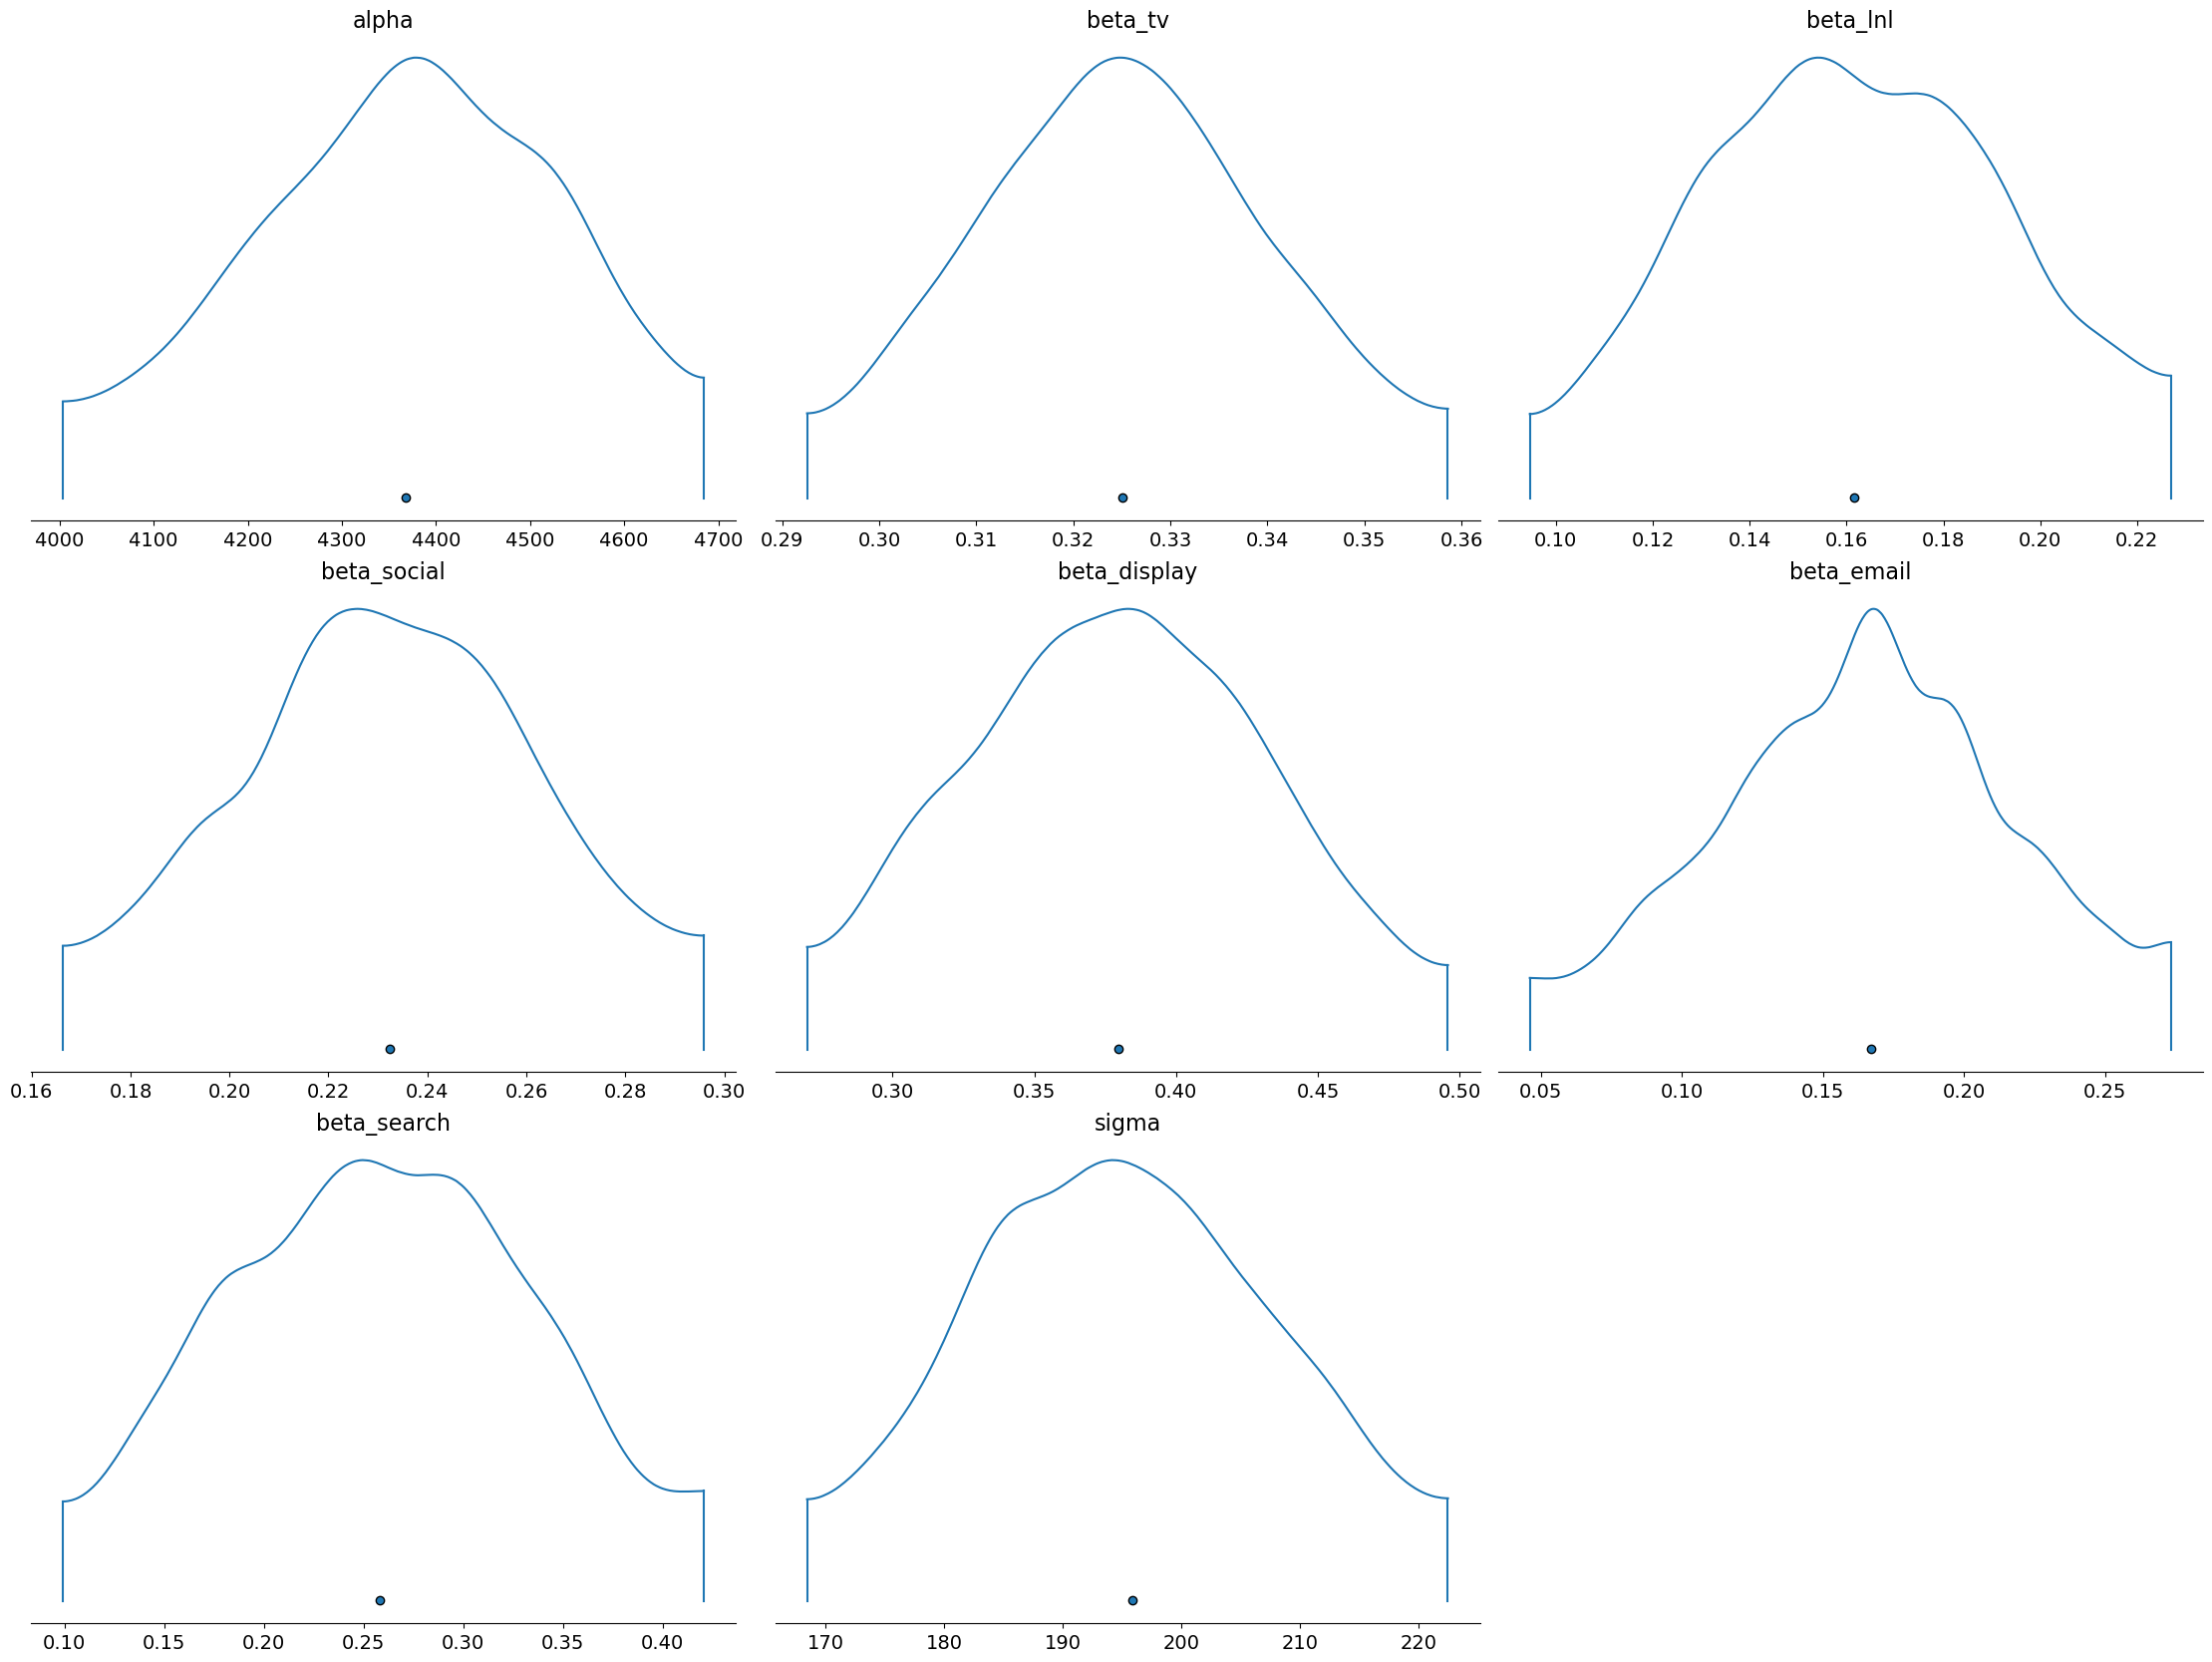

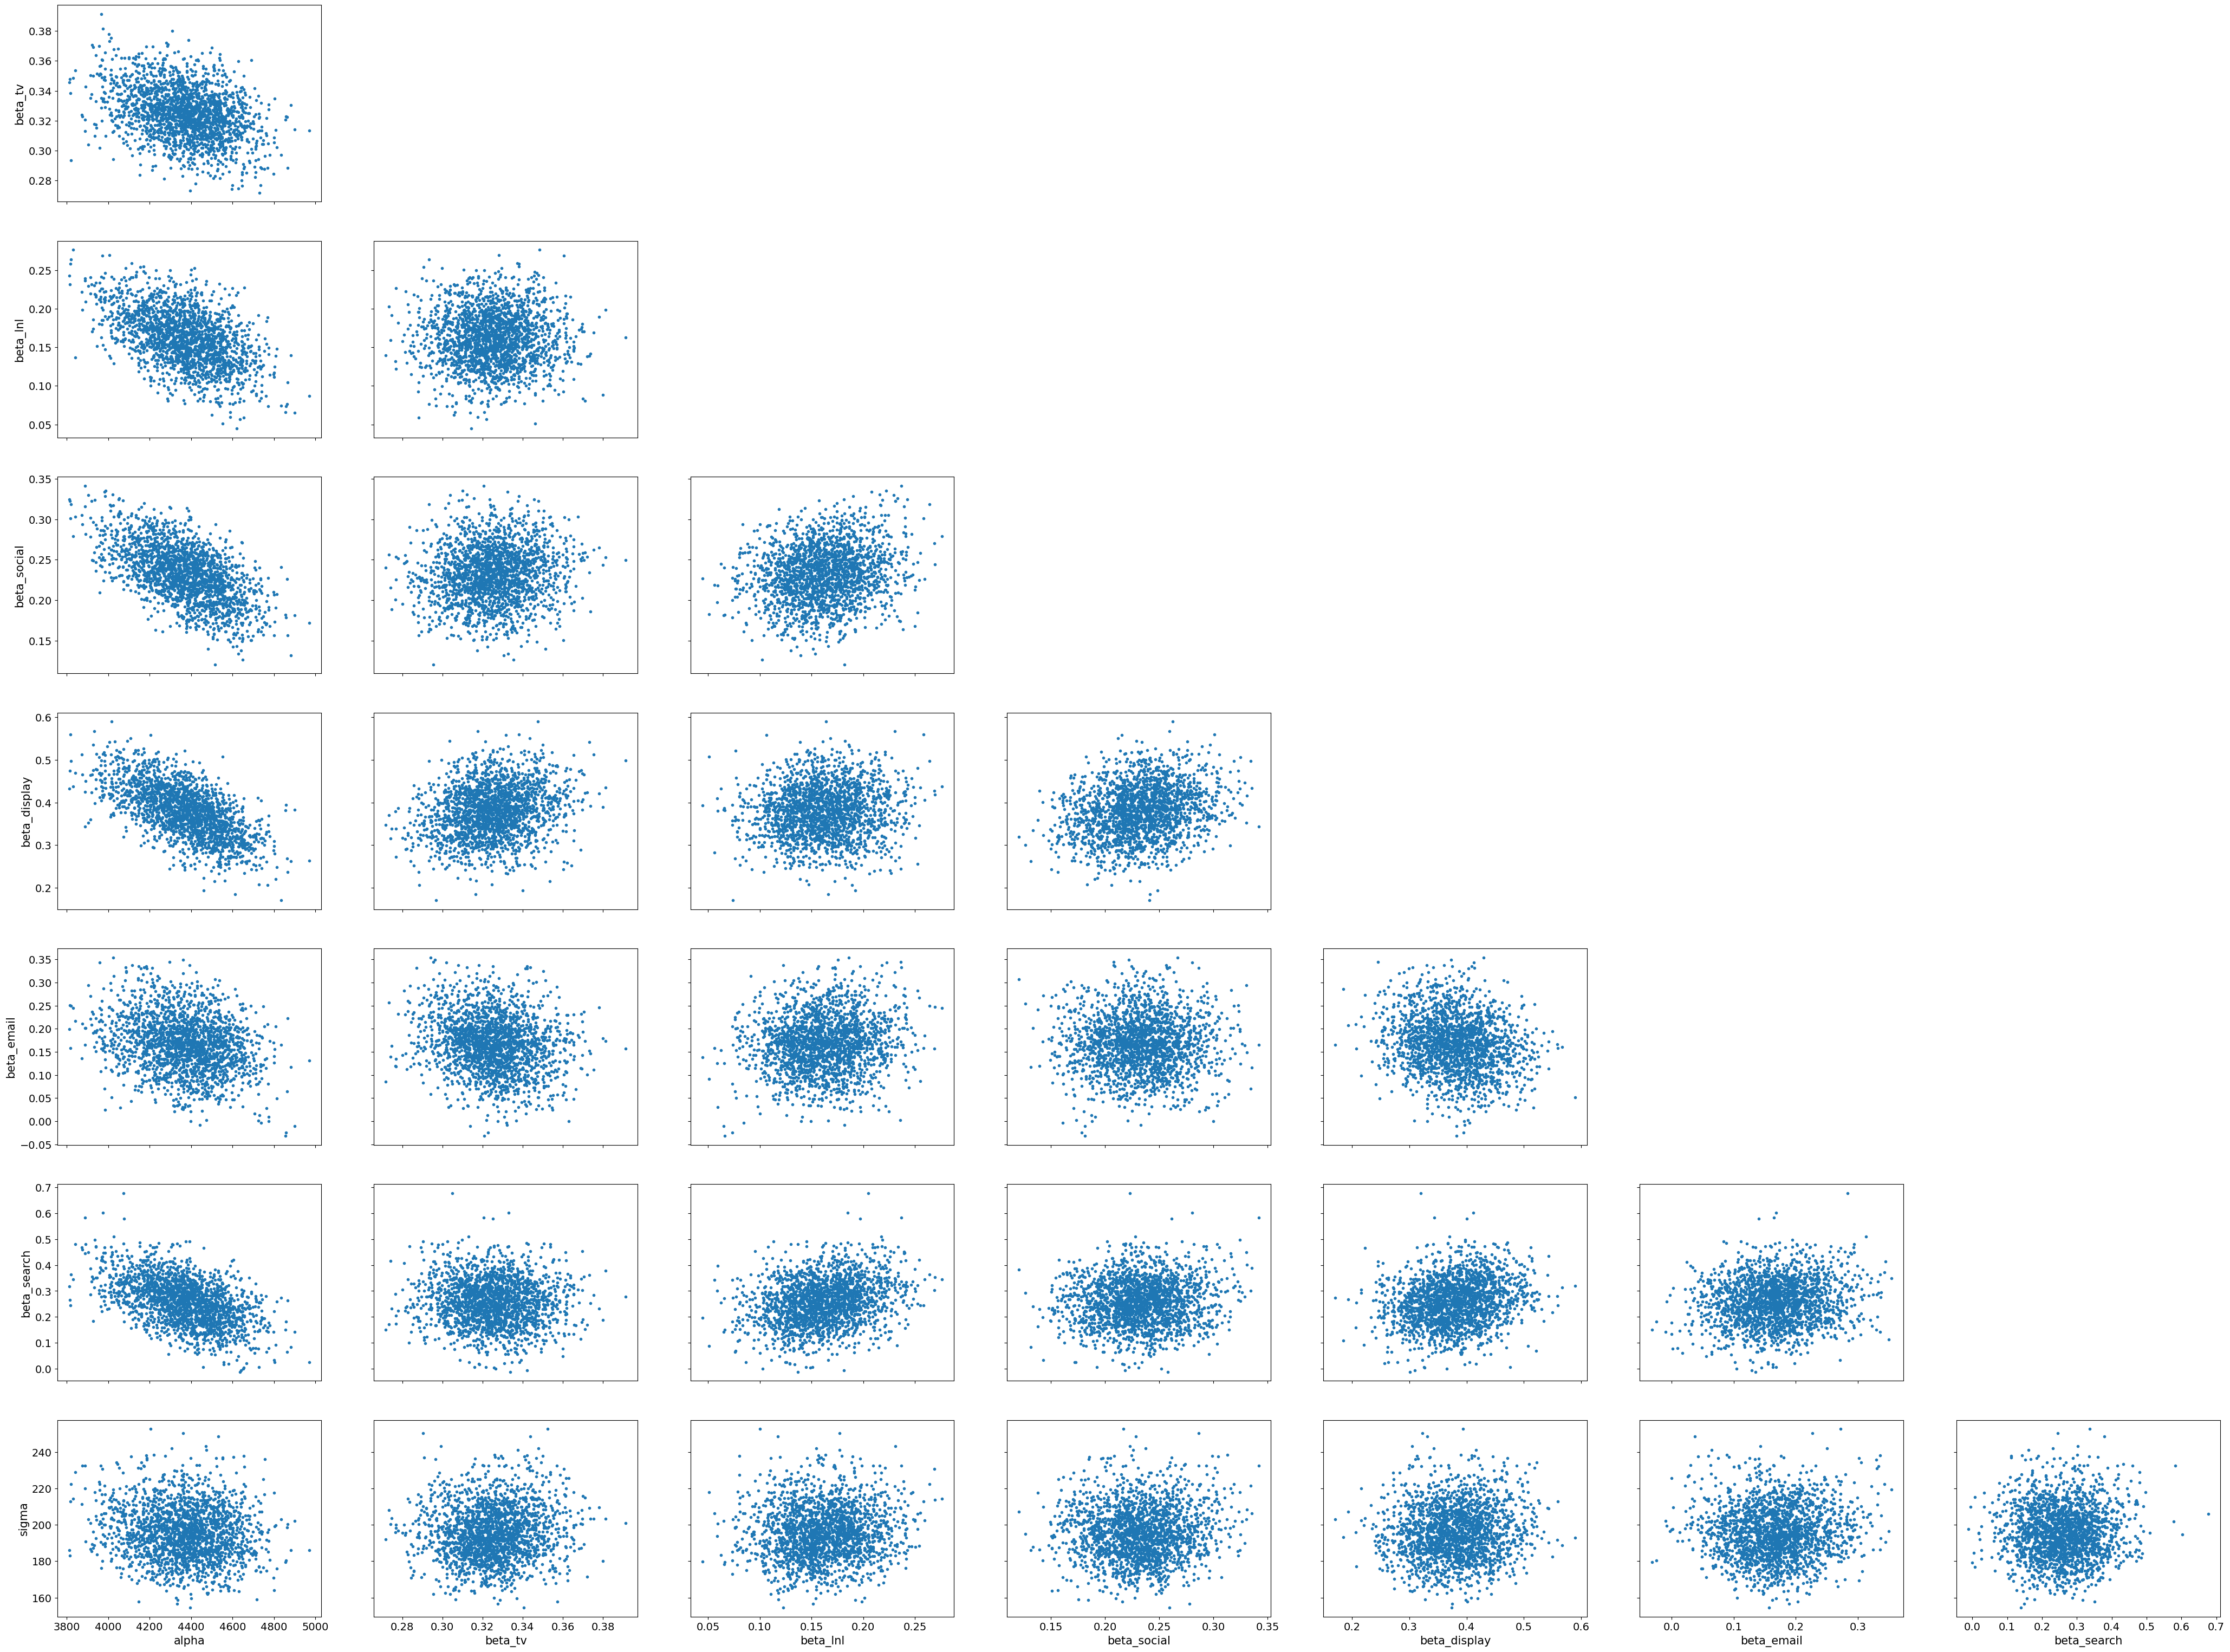

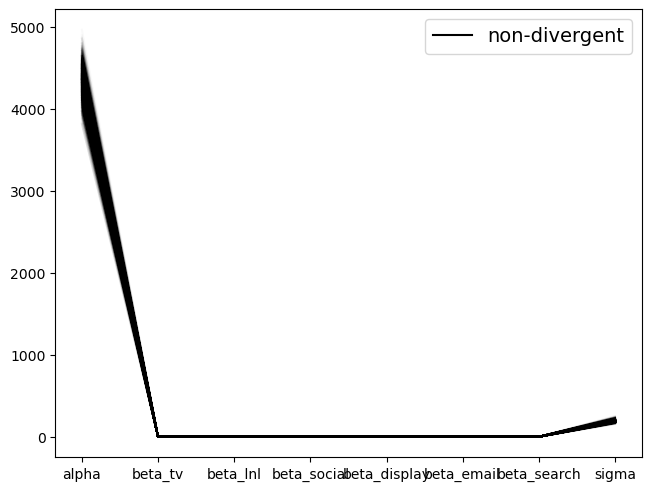

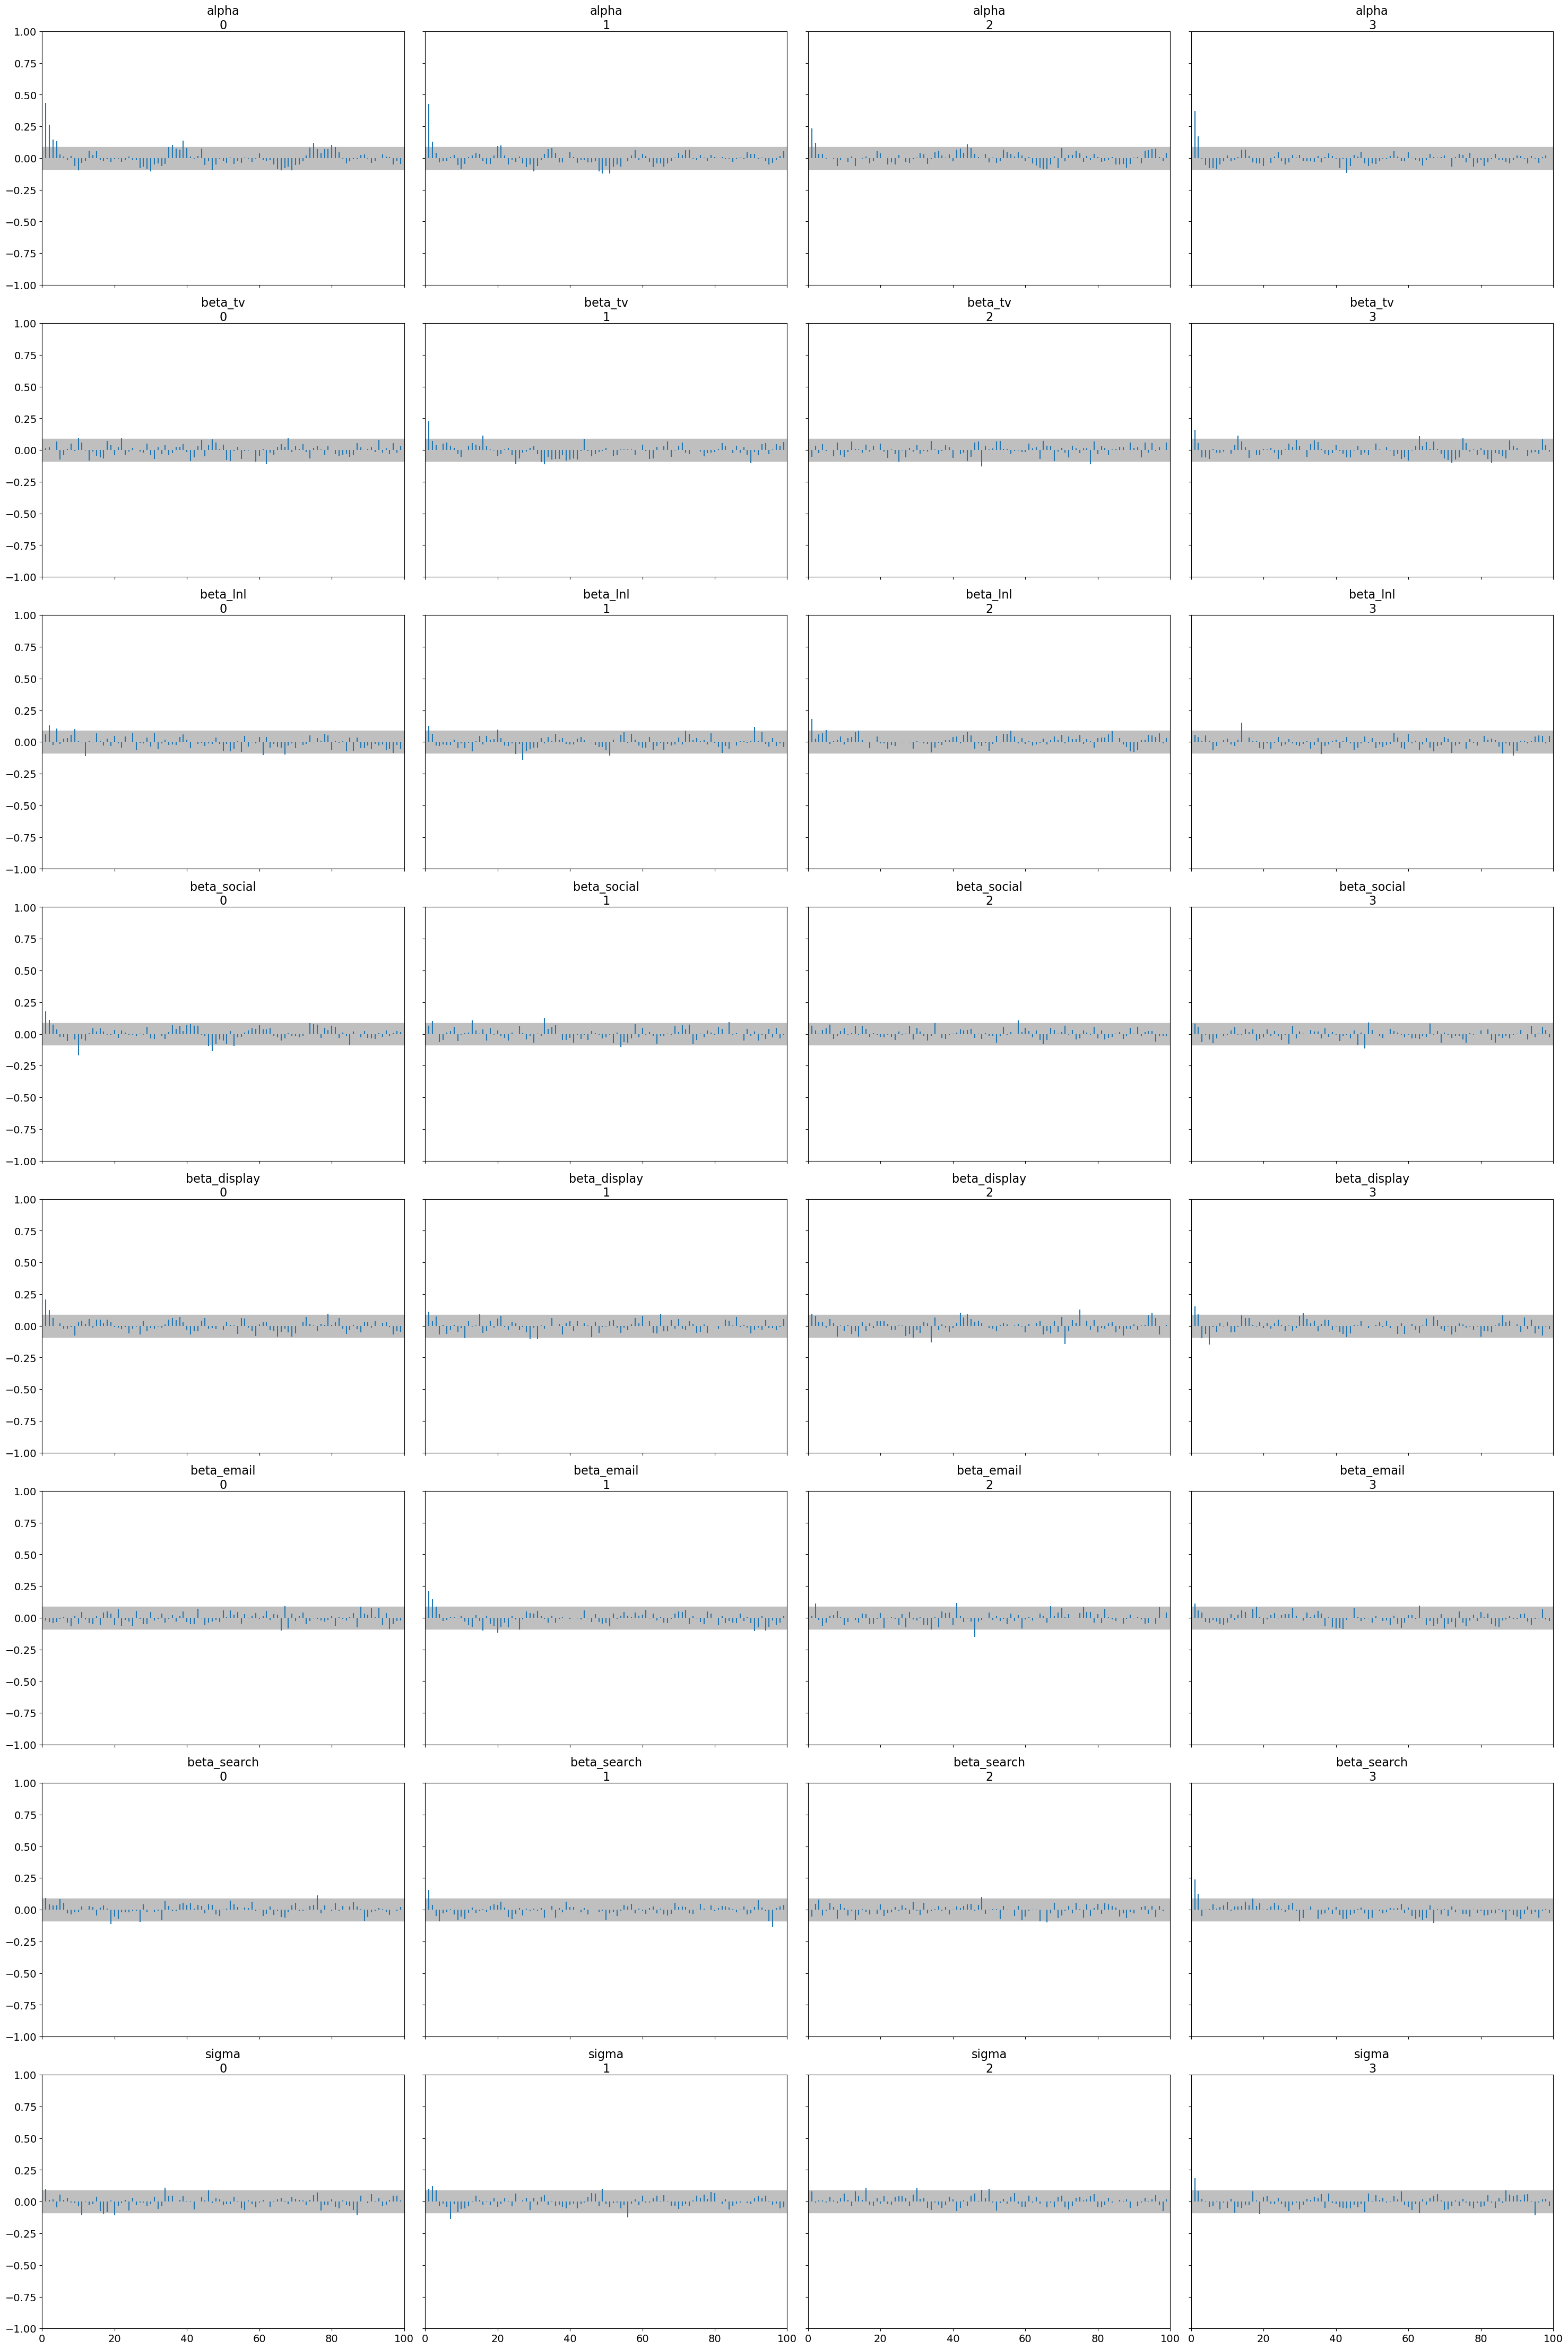

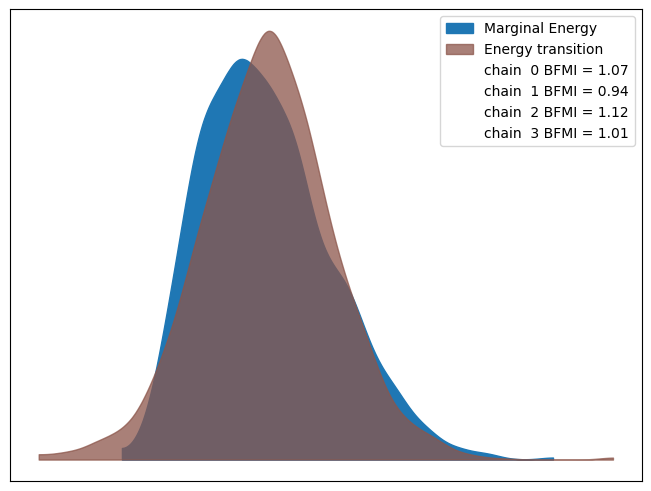

In [23]:
 
# # Step 7: idata Comparison
# waic = pm.waic(trace, idata)  # Calculate WAIC for idata comparison
# loo = pm.loo(trace, idata)  # Calculate LOO for model comparison


az.plot_trace(idata)
az.plot_posterior(idata)

az.plot_forest(idata)
az.plot_density(idata)
az.plot_pair(idata)
az.plot_parallel(idata)
az.plot_autocorr(idata)
az.plot_energy(idata)

# 3) TENSORFLOW

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from datetime import datetime
import os
import time

from datetime import datetime

In [10]:
biggest_number = 1000
seed = 42
iter_sampling = 1000
iter_warmup = 1000
chains = 4
thin = 1
adapt_delta = 0.95
max_treedepth = 15


num_results = iter_sampling
num_burnin_steps = iter_warmup
target_accept = adapt_delta  # Target acceptance rate, equivalent to 'adapt_delta' in Stan and 'target_accept' in PyMC3

records = []

step_size = 0.1  # Initial step size

## TIME

In [16]:
tfd = tfp.distributions
tfb = tfp.bijectors


tf_file_path = './time_outputs/tf.csv'
records = []

# for seed in np.random.randint(1, 10000, size=1):
#     for N in np.linspace(100, biggest_number, 1):
for seed in [42]:
    tf.random.set_seed(seed)
    
    for N in [100]:
        df = pd.read_csv(f'./synthetic_data/marketing_data_samples_{int(N)}.csv')

        data_for_tf = {
            'tv': df['tv'].values.astype(np.float32),
            'lnl': df['lnl'].values.astype(np.float32),
            'social': df['social'].values.astype(np.float32),
            'display': df['display'].values.astype(np.float32),
            'email': df['email'].values.astype(np.float32),
            'search': df['search'].values.astype(np.float32),
            'sales': df['sales'].values.astype(np.float32),
        }

        # Define prior distributions for the model parameters
        initial_alpha = tf.zeros([], name='init_alpha')
        initial_beta_tv = tf.zeros([], name='init_beta_tv')
        initial_beta_lnl = tf.zeros([], name='init_beta_lnl')  
        initial_beta_social = tf.zeros([], name='init_beta_social')
        initial_beta_display = tf.zeros([], name='init_beta_display')
        initial_beta_email = tf.zeros([], name='init_beta_email')
        initial_beta_search = tf.zeros([], name='init_beta_search')
        initial_sigma = tf.ones([], name='init_sigma')

        def joint_log_prob(tv, lnl, social, display, email, search, sales, alpha, beta_tv, beta_lnl, beta_social, beta_display, beta_email, beta_search, sigma):
            # Likelihood of observed data
            mu = alpha + beta_tv * tv + beta_lnl * lnl + beta_social * social + beta_display * display + beta_email * email + beta_search * search
            sales_likelihood = tfd.Normal(loc=mu, scale=sigma)

            return tf.reduce_sum(sales_likelihood.log_prob(sales))
        
        # Define a closure over your data for the log probability function
        def unnormalized_log_posterior(alpha, beta_tv, beta_lnl, beta_social, beta_display, beta_email, beta_search, sigma):
            return joint_log_prob(data_for_tf['tv'], data_for_tf['lnl'], data_for_tf['social'], data_for_tf['display'], data_for_tf['email'], data_for_tf['search'], data_for_tf['sales'], 
                                  alpha, beta_tv, beta_lnl, beta_social, beta_display, beta_email, beta_search, sigma)

         

        # MCMC sampling (this is a placeholder setup, ensure all variables and functions are correctly defined)
        num_results = 10000  # Number of MCMC samples to draw
        num_burnin_steps = 3000  # Number of burn-in steps to discard

        # Define the MCMC sampler
        hmc = tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=unnormalized_log_posterior,
                num_leapfrog_steps=3,
                step_size=0.01,
            )
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
                inner_kernel=hmc,
                num_adaptation_steps=int(num_burnin_steps * 0.8),
                target_accept_prob=0.65,
            )
        
        # Initialize start_time before sampling begins
        start_time = time.time()

        # Run the MCMC sampler
        states, kernel_results = tfp.mcmc.sample_chain(
            num_results=num_results,
            num_burnin_steps=num_burnin_steps,
            current_state=[
                    initial_alpha, initial_beta_tv, initial_beta_lnl,  
                    initial_beta_social, initial_beta_display, initial_beta_email,
                    initial_beta_search, initial_sigma
                    ],
            kernel=adaptive_hmc,
            trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
        )
        fit_time = time.time() - start_time
        now = datetime.now()

        # Assuming you handle results and diagnostics similar to the Stan version
        # For TensorFlow Probability, diagnostics and summary statistics might need to be calculated manually or with other TFP utilities

        record = {
          'seed': seed,
          'date': now.strftime('%y%m%d'),
          'seed-date': now.strftime('%y%m%d') + '-' + str(seed),
          'time': now.strftime('%y%m%d%H%M'),
          'model' :'TensorFlow',
          'N' : len(df),
          'fit_time' : fit_time,        
          
        }
        
        records.append(record)

# The CSV handling remains the same as in the original script
# Check if the CSV file exists
if os.path.exists(tf_file_path):
    # Read the existing CSV file
    df_existing = pd.read_csv(tf_file_path)
    
    # Convert the list of new records into a DataFrame
    df_new_records = pd.DataFrame(records)
    
    # Append the new records to the existing DataFrame
    df_updated = pd.concat([df_existing, df_new_records], ignore_index=True)

else:
    # If the file does not exist, create a DataFrame from the new records
    df_updated = pd.DataFrame(records)

# Save the updated DataFrame to a CSV file
df_updated.to_csv(tf_file_path, index=False)

KeyboardInterrupt: 

## MEMORY

In [ ]:
biggest_number = 1000
seed = 42
iter_sampling = 1000
iter_warmup = 1000
chains = 4
thin = 1
adapt_delta = 0.95
max_treedepth = 15

pymc3_memory = './pymc3_outputs/pymc3_memory.csv'

pymc3_memory_trials = []

for seed in np.random.randint(1, 10000, size=3):
    for N in np.linspace(100, 1000, 10):
    
        def run_pymc3_model():

            df = pd.read_csv(f'./synthetic_data/marketing_data_samples_{int(N)}.csv')

            with pm.Model() as marketing_mix_model:
                # Priors
                alpha = pm.Normal('alpha', mu=0, sd=1000)
                beta_tv = pm.Normal('beta_tv', mu=0, sd=1000)
                beta_lnl = pm.Normal('beta_lnl', mu=0, sd=1000)
                beta_social = pm.Normal('beta_social', mu=0, sd=1000)
                beta_display = pm.Normal('beta_display', mu=0, sd=1000)
                beta_email = pm.Normal('beta_email', mu=0, sd=1000)
                beta_search = pm.Normal('beta_search', mu=0, sd=1000)
                sigma = pm.HalfNormal('sigma', sd=1000)

                # Expected value of outcome
                expected_sales = alpha + beta_tv * df['tv'] + beta_lnl * df['lnl'] + beta_social * df['social'] + beta_display * df['display'] + beta_email * df['email'] + beta_search * df['search']

                # Likelihood of observations
                sales_obs = pm.Normal('sales_obs', mu=expected_sales, sd=sigma, observed=df['sales'])

                start_time = time.time()

                # Sample from the posterior
                trace = pm.sample(iter_sampling, tune=iter_warmup, chains=chains, random_seed=int(seed), target_accept=adapt_delta, max_treedepth=max_treedepth)

                fit_time = time.time() - start_time

            # Optionally, process the trace further here

            return fit_time, len(df)  # Returning the fit time and number of data points

        # Correctly capture the return values from memory_usage
        mem_usage_result = memory_usage((run_pymc3_model), max_usage=True, include_children=True, retval=True)

        # Extract the return value (which is the last element of the list) 
        # and calculate peak memory usage correctly
        fit_time, num_data_points = mem_usage_result[-1]  # This is the correct extraction of return values
        peak_memory = max(mem_usage_result[:-1])  # Calculate peak memory usage excluding the return value

        trial = {
            'seed': seed,
            'date-seed': now.strftime('%y%m%d') + '-' + str(int(seed)),  
            'peak_memory': peak_memory,
            'fit_time': fit_time,
            'N': num_data_points
        }
        print(f"Seed: {seed}, Peak memory usage: {peak_memory} MiB, Fit time: {fit_time} seconds, Data points: {num_data_points}")
        pymc3_memory_trials.append(trial)


pymc3_memory_trials_df = pd.DataFrame(pymc3_memory_trials)
#save to csv but if file exists, append to it
if os.path.exists(pymc3_memory):
    pymc3_memory_trials_df.to_csv(pymc3_memory, mode='a', header=False, index=False)
else:
    pymc3_memory_trials_df.to_csv(pymc3_memory, index=False)
  

In [ ]:
biggest_number = 1000
seed = 42
iter_sampling = 1000
iter_warmup = 1000
chains = 4
thin = 1
adapt_delta = 0.95
max_treedepth = 15

tf_memory = './tf_outputs/tf_memory.csv'
tf_memory_trials = []


tfd = tfp.distributions
tfb = tfp.bijectors


tf_file_path = './time_outputs/tf.csv'
records = []

# for seed in np.random.randint(1, 10000, size=1):
#     for N in np.linspace(100, biggest_number, 1):
for seed in [42]:
    tf.random.set_seed(seed)
    
    for N in [100]:
        df = pd.read_csv(f'./synthetic_data/marketing_data_samples_{int(N)}.csv')

        data_for_tf = {
            'tv': df['tv'].values.astype(np.float32),
            'lnl': df['lnl'].values.astype(np.float32),
            'social': df['social'].values.astype(np.float32),
            'display': df['display'].values.astype(np.float32),
            'email': df['email'].values.astype(np.float32),
            'search': df['search'].values.astype(np.float32),
            'sales': df['sales'].values.astype(np.float32),
        }

        # Define prior distributions for the model parameters
        initial_alpha = tf.zeros([], name='init_alpha')
        initial_beta_tv = tf.zeros([], name='init_beta_tv')
        initial_beta_lnl = tf.zeros([], name='init_beta_lnl')  
        initial_beta_social = tf.zeros([], name='init_beta_social')
        initial_beta_display = tf.zeros([], name='init_beta_display')
        initial_beta_email = tf.zeros([], name='init_beta_email')
        initial_beta_search = tf.zeros([], name='init_beta_search')
        initial_sigma = tf.ones([], name='init_sigma')

        def joint_log_prob(tv, lnl, social, display, email, search, sales, alpha, beta_tv, beta_lnl, beta_social, beta_display, beta_email, beta_search, sigma):
            # Likelihood of observed data
            mu = alpha + beta_tv * tv + beta_lnl * lnl + beta_social * social + beta_display * display + beta_email * email + beta_search * search
            sales_likelihood = tfd.Normal(loc=mu, scale=sigma)

            return tf.reduce_sum(sales_likelihood.log_prob(sales))
        
        # Define a closure over your data for the log probability function
        def unnormalized_log_posterior(alpha, beta_tv, beta_lnl, beta_social, beta_display, beta_email, beta_search, sigma):
            return joint_log_prob(data_for_tf['tv'], data_for_tf['lnl'], data_for_tf['social'], data_for_tf['display'], data_for_tf['email'], data_for_tf['search'], data_for_tf['sales'], 
                                  alpha, beta_tv, beta_lnl, beta_social, beta_display, beta_email, beta_search, sigma)

        
        
        # Set random seed for reproducibility
        tf.random.set_seed(seed)

        # MCMC sampling (this is a placeholder setup, ensure all variables and functions are correctly defined)
        num_results = 10000  # Number of MCMC samples to draw
        num_burnin_steps = 3000  # Number of burn-in steps to discard

        # Define the MCMC sampler
        hmc = tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=unnormalized_log_posterior,
                num_leapfrog_steps=3,
                step_size=0.01,
            )
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
                inner_kernel=hmc,
                num_adaptation_steps=int(num_burnin_steps * 0.8),
                target_accept_prob=0.65,
            )
        
        # Initialize start_time before sampling begins
        start_time = time.time()

        # Run the MCMC sampler
        states, kernel_results = tfp.mcmc.sample_chain(
            num_results=num_results,
            num_burnin_steps=num_burnin_steps,
            current_state=[
                    initial_alpha, initial_beta_tv, initial_beta_lnl,  
                    initial_beta_social, initial_beta_display, initial_beta_email,
                    initial_beta_search, initial_sigma
                    ],
            kernel=adaptive_hmc,
            trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
        )
        fit_time = time.time() - start_time
        now = datetime.now()

        # Assuming you handle results and diagnostics similar to the Stan version
        # For TensorFlow Probability, diagnostics and summary statistics might need to be calculated manually or with other TFP utilities

        record = {
          'seed': seed,
          'date': now.strftime('%y%m%d'),
          'seed-date': now.strftime('%y%m%d') + '-' + str(seed),
          'time': now.strftime('%y%m%d%H%M'),
          'model' :'TensorFlow',
          'N' : len(df),
          'fit_time' : fit_time,        
          
        }
        
        records.append(record)








tf_memory_trials_df = pd.DataFrame(tf_memory_trials)
#save to csv but if file exists, append to it
if os.path.exists(tf_memory):
    tf_memory_trials_df.to_csv(tf_memory, mode='a', header=False, index=False)
else:
    tf_memory_trials_df.to_csv(tf_memory, index=False)
  




# The CSV handling remains the same as in the original script
# Check if the CSV file exists
if os.path.exists(tf_file_path):
    # Read the existing CSV file
    df_existing = pd.read_csv(tf_file_path)
    
    # Convert the list of new records into a DataFrame
    df_new_records = pd.DataFrame(records)
    
    # Append the new records to the existing DataFrame
    df_updated = pd.concat([df_existing, df_new_records], ignore_index=True)

else:
    # If the file does not exist, create a DataFrame from the new records
    df_updated = pd.DataFrame(records)

# Save the updated DataFrame to a CSV file
df_updated.to_csv(tf_file_path, index=False)

# =========================

# =========================

# Conclusion

<table>
  <thead style="background-color: #7A8450; color: white;">
    <tr>
      <th>Feature/Platform</th>
      <th>PyMC</th>
      <th>Stan</th>
      <th>TensorFlow Probability</th>
      <th>Turing.jl</th>
    </tr>
  </thead>
  <tbody>
        <tr style="background-color: #000000;">
       <td>Difficulty of Model migraiton</td>
      <td>Low (Pythonic)</td>
      <td>None (Stan language) </td>
      <td>Medium - Hard (TensorFlow API + GPU usage)</td>
      <td>Very Hard (Julian)</td>
    </tr> 
    <tr style="background-color: #95969D; color:black">
      <td>Documentation</td>
      <td>Super Good (Python ecosystem)</td>
      <td>Good (R, Python, etc.)</td>
      <td>Best (TensorFlow ecosystem)</td>
      <td>Basic (Julia ecosystem)</td>
    </tr>
    
  </tbody>
</table>


In [9]:
from memory_profiler import memory_usage
from time import sleep

def f():
    # a function that with growing
    # memory consumption
    a = [0] * 1000
    sleep(.1)
    b = a * 100
    sleep(.1)
    c = b * 100
    return a

mem_usage = memory_usage(f)
print('Memory usage (in chunks of .1 seconds): %s' % mem_usage)
print('Maximum memory usage: %s' % max(mem_usage))

Memory usage (in chunks of .1 seconds): [269.16015625, 268.64453125, 268.64453125, 268.64453125, 268.64453125]
Maximum memory usage: 269.16015625


---
---
---

# Anexes


## KERNELS

overview of the primary HMC-related transition kernels available in TFP as of my last update:

1. HamiltonianMonteCarlo (HMC)
Description: This is the basic HMC kernel. It uses gradient information to propose new states in the Markov chain, making large jumps in the state space with relatively few evaluations of the target distribution. It requires tuning of parameters like the number of leapfrog steps and the step size.
Key Parameters:
step_size: The size of the steps to take during the leapfrog integration.
num_leapfrog_steps: The number of leapfrog steps to take per proposal.

2. NoUTurnSampler (NUTS)
Description: An extension of HMC that automatically tunes the number of leapfrog steps to take in each iteration, eliminating the need to manually set this parameter. It does this by running the leapfrog integrator forward and backward until it makes a "U-turn" back toward its starting point.
Key Parameters:
step_size: Initial step size for the leapfrog integrator.
max_tree_depth: Maximum depth of the binary tree built by NUTS, controlling the maximum number of leapfrog steps.

3. SimpleStepSizeAdaptation
Description: A wrapper or meta-kernel that automatically tunes the step size of an underlying HMC or NUTS kernel to achieve a desired acceptance rate. It's designed to be used during the burn-in period of the chain.
Key Parameters:
inner_kernel: The HMC or NUTS kernel to adapt.
num_adaptation_steps: The number of steps over which to adapt the step size.
target_accept_prob: The desired acceptance probability to guide the step size adaptation.
4. DualAveragingStepSizeAdaptation
Description: Another wrapper for adapting the step size of an HMC or NUTS kernel, using the dual averaging algorithm. It's particularly useful for targeting a specific acceptance rate over the course of the entire sampling run, including both burn-in and sampling phases.
Key Parameters:
inner_kernel: The HMC or NUTS kernel being adapted.
num_adaptation_steps: The number of steps to use for adaptation.
target_accept_prob: The desired acceptance probability.
5. TransformedTransitionKernel
Description: A kernel that applies a bijector (transformation) to the state space, allowing the HMC or NUTS sampler to operate in a transformed space. This can improve sampling efficiency for constrained parameters or parameters with problematic geometries.
Key Parameters:
inner_kernel: The HMC or NUTS kernel to apply the transformation to.
bijector: The bijector to use for transforming the space.
6. GeneralizedLeapfrogIntegrator
Description: While not a transition kernel per se, this is an integrator used within the HMC kernel to perform the leapfrog steps. It's a more general version that allows for modifications to the leapfrog algorithm, potentially improving numerical stability or efficiency.
7. RandomWalkMetropolis-HMC
Description: A hybrid approach that combines aspects of the Random Walk Metropolis algorithm with HMC, aiming to balance the exploration efficiency of HMC with the simplicity and robustness of random walk proposals.
Key Parameters:
Varies depending on the specific implementation and combination of algorithms.
These kernels and integrators can be combined or used with various adaptations to optimize the sampling process for specific models or datasets. The choice of kernel and configuration often depends on the problem at hand, including the complexity of the model, the geometry of the posterior distribution, and the desired efficiency and accuracy of the sampling process. TFP's modular design allows for a high degree of flexibility and customization in constructing MCMC algorithms.

### Visual

<Axes: >

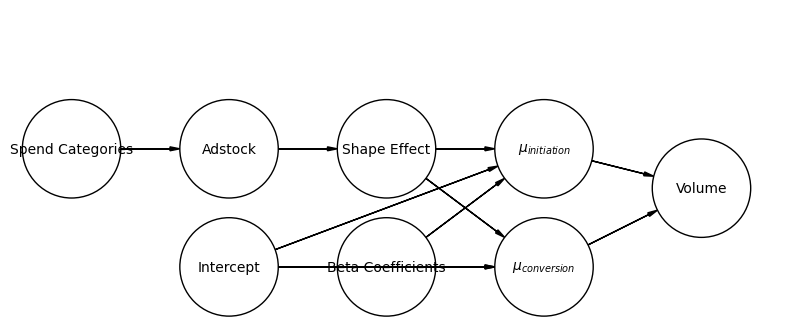

In [ ]:


# Initialize the PGM object with an updated shape for more space
pgm = daft.PGM(shape=[10.0, 4.0])

# Define the nodes with increased scale and more space between them
pgm.add_node("spend", r"Spend Categories", 1, 4.5, scale=2.5)
pgm.add_node("adstock", r"Adstock", 3, 4.5, scale=2.5)
pgm.add_node("shape", r"Shape Effect", 5, 4.5, scale=2.5)
pgm.add_node("intercept", r"Intercept", 3, 3, scale=2.5)
pgm.add_node("beta", r"Beta Coefficients", 5, 3, scale=2.5)
pgm.add_node("mu_initiation", r"$\mu_{initiation}$", 7, 4.5, scale=2.5)
pgm.add_node("mu_conversion", r"$\mu_{conversion}$", 7, 3, scale=2.5)
pgm.add_node("volume", r"Volume", 9, 4, scale=2.5)

# Define the edges with adjusted positions
pgm.add_edge("spend", "adstock")
pgm.add_edge("adstock", "shape")
pgm.add_edge("shape", "mu_initiation")
pgm.add_edge("shape", "mu_conversion")
pgm.add_edge("intercept", "mu_initiation")
pgm.add_edge("intercept", "mu_conversion")
pgm.add_edge("beta", "mu_initiation")
pgm.add_edge("beta", "mu_conversion")
pgm.add_edge("mu_initiation", "volume")
pgm.add_edge("mu_conversion", "volume")

# Render the graph with the updated layout
pgm.render()


<Axes: >

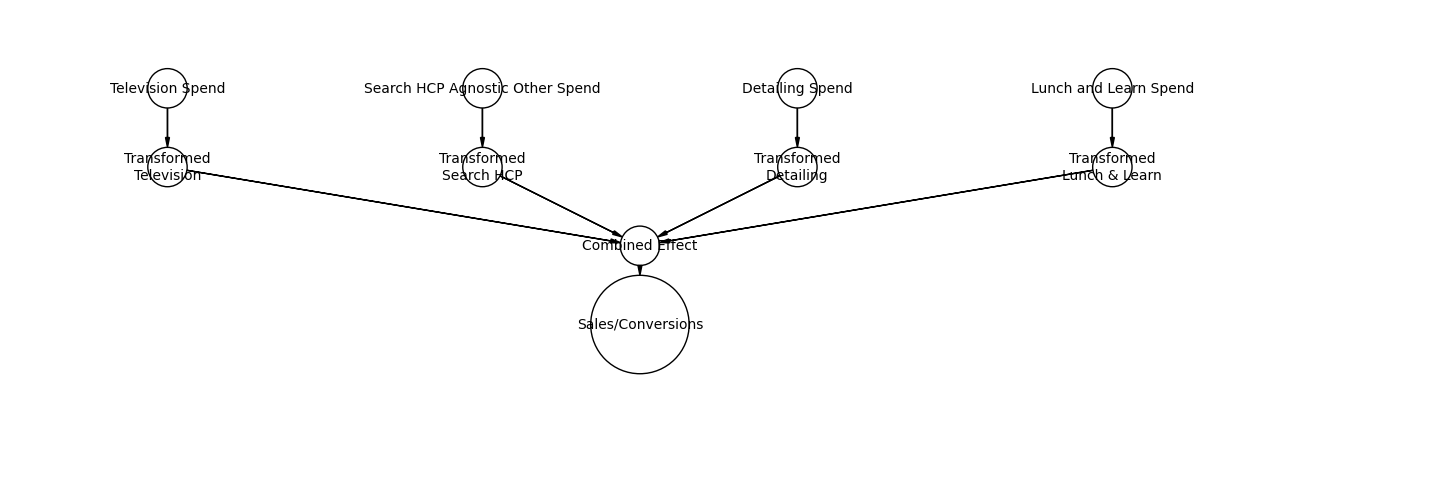

In [ ]:
import daft

# Initialize a PGM with adjusted dimensions for clarity
pgm = daft.PGM(shape=[18.0, 6.0], origin=[0, 0])

# Nodes for spend categories
pgm.add_node("television", "Television Spend", 2, 5, scale=1)
pgm.add_node("search_hcp", "Search HCP Agnostic Other Spend", 6, 5, scale=1)
pgm.add_node("detailing", "Detailing Spend", 10, 5, scale=1)
pgm.add_node("lunch_learn", "Lunch and Learn Spend", 14, 5, scale=1)

# Nodes for adstock transformations (if applicable)
pgm.add_node("transformed_television", "Transformed\nTelevision", 2, 4, scale=1)
pgm.add_node("transformed_search_hcp", "Transformed\nSearch HCP", 6, 4, scale=1)
pgm.add_node("transformed_detailing", "Transformed\nDetailing", 10, 4, scale=1)
pgm.add_node("transformed_lunch_learn", "Transformed\nLunch & Learn", 14, 4, scale=1)

# Node for combined effect
pgm.add_node("combined_effect", "Combined Effect", 8, 3, scale=1)

# Node for outcome
pgm.add_node("outcome", "Sales/Conversions", 8, 2, scale=2.5)

# Edges from spend categories to their adstocks
pgm.add_edge("television", "transformed_television")
pgm.add_edge("search_hcp", "transformed_search_hcp")
pgm.add_edge("detailing", "transformed_detailing")
pgm.add_edge("lunch_learn", "transformed_lunch_learn")

# Edges from adstocks to combined effect
pgm.add_edge("transformed_television", "combined_effect")
pgm.add_edge("transformed_search_hcp", "combined_effect")
pgm.add_edge("transformed_detailing", "combined_effect")
pgm.add_edge("transformed_lunch_learn", "combined_effect")

# Edge from combined effect to outcome
pgm.add_edge("combined_effect", "outcome")

# Render the graph
pgm.render()


In [ ]:
# Visual


# Initialize the PGM object with an updated shape for more space
pgm = daft.PGM(shape=[10.0, 4.0])

# Define the nodes with increased scale and more space between them
pgm.add_node("spend", r"Spend Categories", 1, 4.5, scale=2.5)
pgm.add_node("adstock", r"Adstock", 3, 4.5, scale=2.5)
pgm.add_node("shape", r"Shape Effect", 5, 4.5, scale=2.5)
pgm.add_node("intercept", r"Intercept", 3, 3, scale=2.5)
pgm.add_node("beta", r"Beta Coefficients", 5, 3, scale=2.5)
pgm.add_node("mu_initiation", r"$\mu_{initiation}$", 7, 4.5, scale=2.5)
pgm.add_node("mu_conversion", r"$\mu_{conversion}$", 7, 3, scale=2.5)
pgm.add_node("volume", r"Volume", 9, 4, scale=2.5)

# Define the edges with adjusted positions
pgm.add_edge("spend", "adstock")
pgm.add_edge("adstock", "shape")
pgm.add_edge("shape", "mu_initiation")
pgm.add_edge("shape", "mu_conversion")
pgm.add_edge("intercept", "mu_initiation")
pgm.add_edge("intercept", "mu_conversion")
pgm.add_edge("beta", "mu_initiation")
pgm.add_edge("beta", "mu_conversion")
pgm.add_edge("mu_initiation", "volume")
pgm.add_edge("mu_conversion", "volume")

# Render the graph with the updated layout
pgm.render()

import daft

# Initialize a PGM with adjusted dimensions for clarity
pgm = daft.PGM(shape=[18.0, 6.0], origin=[0, 0])

# Nodes for spend categories
pgm.add_node("television", "Television Spend", 2, 5, scale=1)
pgm.add_node("search_hcp", "Search HCP Agnostic Other Spend", 6, 5, scale=1)
pgm.add_node("detailing", "Detailing Spend", 10, 5, scale=1)
pgm.add_node("lunch_learn", "Lunch and Learn Spend", 14, 5, scale=1)

# Nodes for adstock transformations (if applicable)
pgm.add_node("transformed_television", "Transformed\nTelevision", 2, 4, scale=1)
pgm.add_node("transformed_search_hcp", "Transformed\nSearch HCP", 6, 4, scale=1)
pgm.add_node("transformed_detailing", "Transformed\nDetailing", 10, 4, scale=1)
pgm.add_node("transformed_lunch_learn", "Transformed\nLunch & Learn", 14, 4, scale=1)

# Node for combined effect
pgm.add_node("combined_effect", "Combined Effect", 8, 3, scale=1)

# Node for outcome
pgm.add_node("outcome", "Sales/Conversions", 8, 2, scale=2.5)

# Edges from spend categories to their adstocks
pgm.add_edge("television", "transformed_television")
pgm.add_edge("search_hcp", "transformed_search_hcp")
pgm.add_edge("detailing", "transformed_detailing")
pgm.add_edge("lunch_learn", "transformed_lunch_learn")

# Edges from adstocks to combined effect
pgm.add_edge("transformed_television", "combined_effect")
pgm.add_edge("transformed_search_hcp", "combined_effect")
pgm.add_edge("transformed_detailing", "combined_effect")
pgm.add_edge("transformed_lunch_learn", "combined_effect")

# Edge from combined effect to outcome
pgm.add_edge("combined_effect", "outcome")

# Render the graph
pgm.render()
